In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import muram as mio
from astropy.io import fits#
import pyflct
import matplotlib.patches as patches
from copy import copy

In [2]:
from matplotlib import font_manager
import matplotlib as mpl
font_path = '/home/mistflow/.fonts/azoft-sans.ttf'  # Your font path goes here
#font_path = '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif', 'DejaVu Sans']
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
#plt.rc('axes', unicode_minus=False)
plt.rcParams["axes.unicode_minus"] = False

In [3]:
from rtfunctions import one_full_fs, sc_2nd_order, calc_lambda_full, calc_lambda_monoc

<p>We want to solve:</p>
<center>$I_\lambda^+ = I_\lambda^0 e^{-\tau_\lambda} + \int_0^{\tau_\lambda}S(t)e^{-t}\,dt$</center>

<p>First order of bussiness is to define discrete grid for spatial coordinate - $\log\tau$ is our choice (this is in continuum)</p>

In [4]:
ND = 91
logtau = np.linspace(-7, 2, ND)
tau = 10**logtau

# We will assume isothermal atmosphere as case scenario, hence define Planck's function
B = np.zeros(ND)
B[:] = 1.0

# line and continuum opacity ratio
lratio = 1E3

<p>But, before we get into this, we need also define wavelength discrete grid. We shall define it in Doppler width units instead of nm</p>

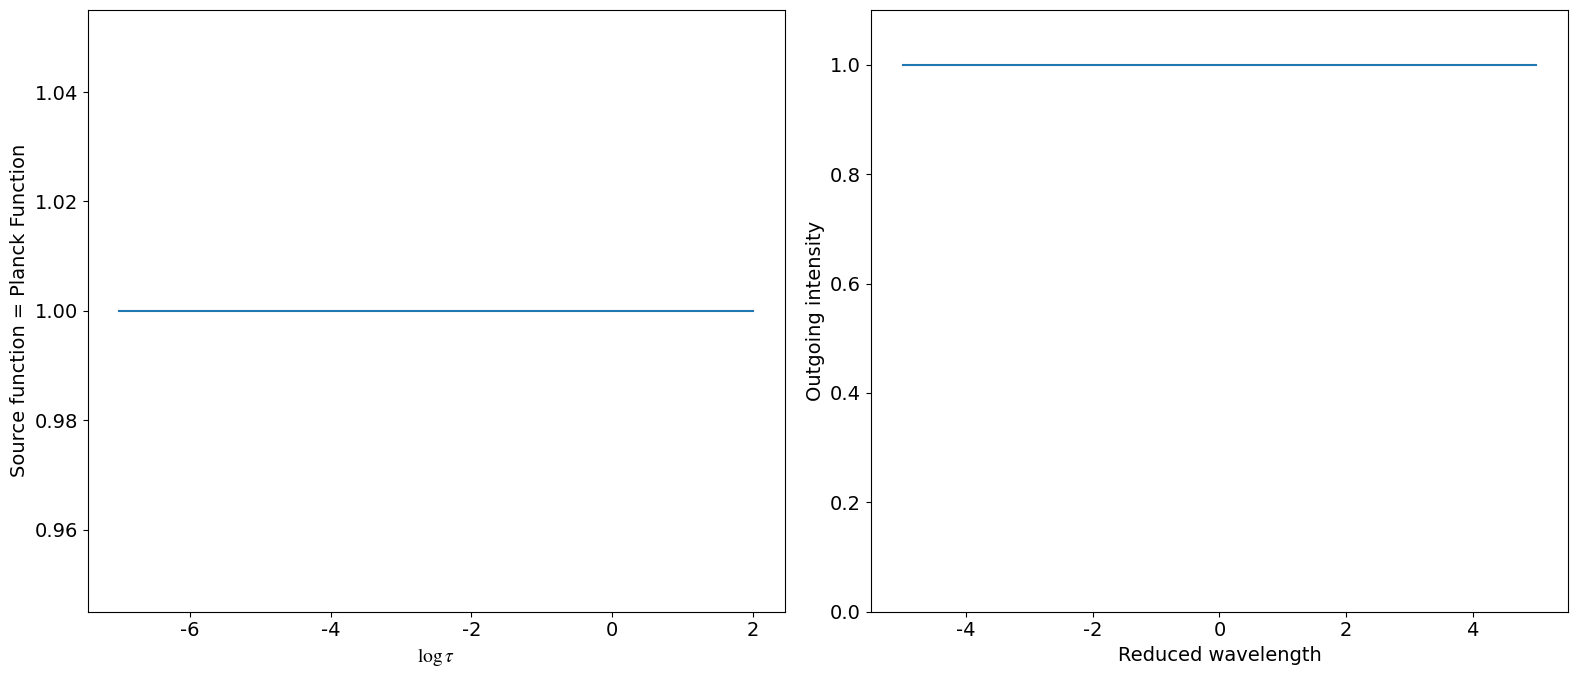

In [5]:
NL = 51
x = np.linspace(-5, 5, NL)
profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))

# Let's plot source function and outgoing intensity after formal solution

I_out = one_full_fs(tau * lratio, B, 1.0, profile, B[-1])

plt.figure(figsize=[16,7])
plt.subplot(121)
plt.plot(logtau, B)
plt.xlabel("$\\log\\tau$")
plt.ylabel("Source function = Planck Function")
plt.subplot(122)
plt.plot(x, I_out)
plt.xlabel("Reduced wavelength")
plt.ylabel("Outgoing intensity")
plt.ylim([0, 1.1])
plt.tight_layout()


<p>There is no spectral line because the atmosphere is isothermal. To study it more carefully, let's calculate intensities at all points </p>

In [6]:
I = np.zeros([ND, NL])

for l in range(0, NL):
    I[:, l] = sc_2nd_order(tau * profile[l] * lratio, B, 1.0, B[-1])[0]

I.shape

(91, 51)

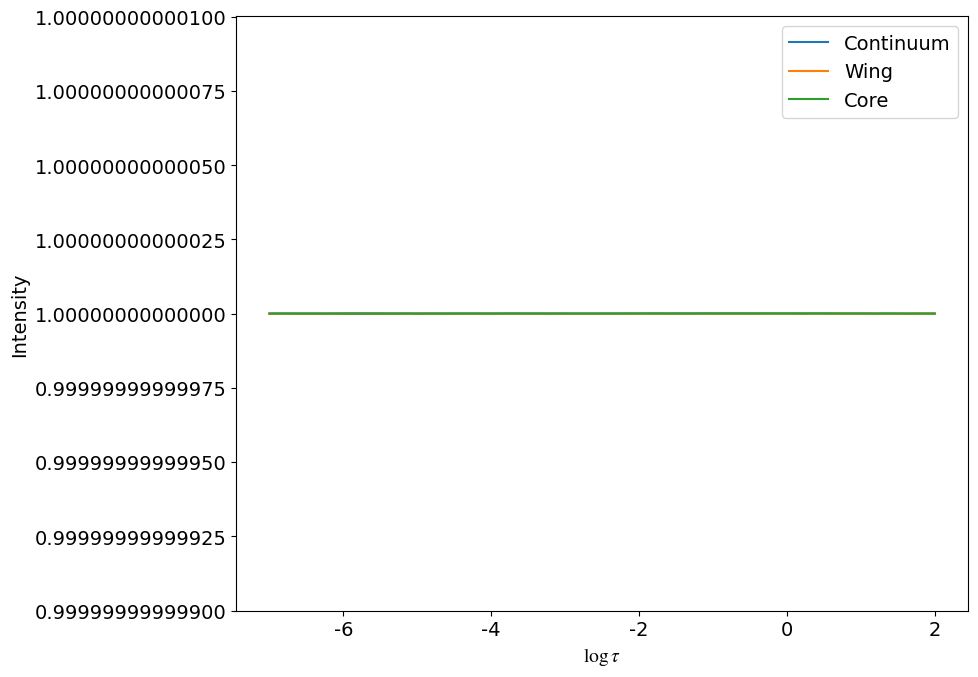

In [7]:
#Now I will plot run of the intensity with depth for few wavelenghts
plt.figure(figsize=[10,7])
plt.plot(logtau,I[:,0],label='Continuum')
plt.plot(logtau,I[:,15],label='Wing')
plt.plot(logtau,I[:,25],label='Core')
plt.legend()
plt.xlabel("$\\log\\tau$")
plt.ylabel("Intensity")
plt.ticklabel_format(useOffset=False)
plt.tight_layout()

<p>For argument's sake, let's calculate the intensity that comes IN the atmosphere - note the different direction and boundary condition</p>

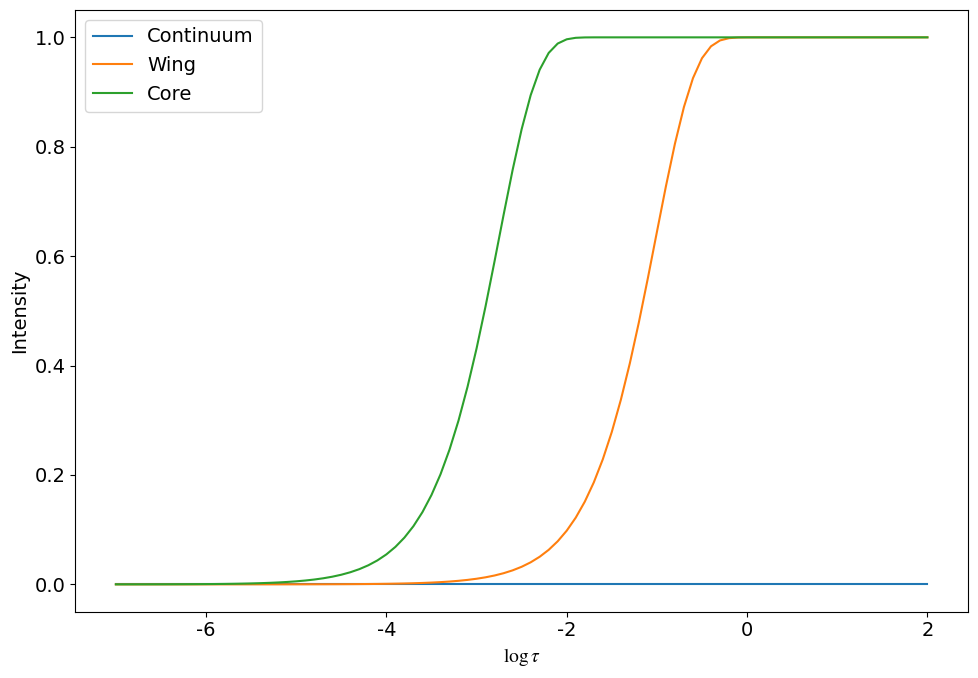

In [8]:
I = np.zeros([ND,NL])
for l in range(0,NL):
    I[:,l] = sc_2nd_order(tau * profile[l] * lratio, B, -1.0, 0.0)[0]
plt.figure(figsize=[10,7])
plt.plot(logtau,I[:,0],label='Continuum')
plt.plot(logtau,I[:,15],label='Wing')
plt.plot(logtau,I[:,25],label='Core')
plt.legend()
plt.xlabel("$\\log\\tau$")
plt.ylabel("Intensity")
plt.ticklabel_format(useOffset=False)
plt.tight_layout()

<p>LTE lines are fairly simple to model. We only need to know $S(\tau)$, where S = B, and then solve:</p>
<center>$I_\lambda^+ = I_\lambda^0 e^{-\tau_\lambda} + \int_0^{\tau_\lambda} S(t)e^{-t}dt$</center>

<p>NLTE lines, however, are complex because in addition to the previous equation we need to solve radiative transfer equation, that, for simplified 2 level atom looks like:</p>
<center>$S = \epsilon B + (1-\epsilon) \frac{1}{2} \iint I(\mu, \lambda) \phi_\lambda d\lambda d\mu$</center>

In [9]:
# Photon destruction probability (the lower this value is, the more NLTE the case is)
eps = np.zeros(ND)
eps[:] = 1E-4

<p>Now, let's solve integral using the quadrature:</p>

In [10]:
# Weights for wavelength 
NL = 21
x = np.linspace(-5, 5, NL)
profile = 1./np.sqrt(np.pi) * np.exp(-(x**2.0)) # Doppler profile
wx = np.zeros(NL)

wx[0] = (x[1] - x[0]) * 0.5
wx[-1] = (x[-1] - x[-2]) * 0.5
wx[1:-1] = (x[2:NL] - x[0:-2]) * 0.5
norm = (np.sum(profile*wx))
wx = wx/norm

# Angle integration:
mu=([1./np.sqrt(3.0)])
wmu=[1.0]
mu=np.cos([0.4793425352,1.0471975512,1.4578547042])
wmu=[.2777777778,0.4444444444,0.2777777778]
NM = mu.shape[0]
mu = np.asarray(mu)
wmu = np.asarray(wmu)
print(NM)
print(mu)
print(profile)

3
[0.88729833 0.5        0.11270167]
[7.83543327e-12 9.05652948e-10 6.34911734e-08 2.69971339e-06
 6.96265260e-05 1.08914212e-03 1.03334927e-02 5.94651446e-02
 2.07553749e-01 4.39391289e-01 5.64189584e-01 4.39391289e-01
 2.07553749e-01 5.94651446e-02 1.03334927e-02 1.08914212e-03
 6.96265260e-05 2.69971339e-06 6.34911734e-08 9.05652948e-10
 7.83543327e-12]


<p>So, let's hop to it and solve RTE - after that we will see how our source function looks:</p>

[0.50005    0.50006894 0.50009277 0.50012277 0.50016054 0.50020808
 0.50026791 0.50034322 0.50043799 0.50055725 0.5007073  0.50089607
 0.50113351 0.50143209 0.50180747 0.50227921 0.50287179 0.50361573
 0.50454903 0.50571884 0.50718344 0.50901452 0.51129975 0.51414544
 0.51767926 0.52205252 0.52744148 0.53404693 0.54209075 0.5518081
 0.56343371 0.57718107 0.59321478 0.61161878 0.63236716 0.65530833
 0.68017462 0.70662316 0.73429617 0.76286529 0.79201416 0.82134278
 0.85024589 0.87787126 0.90323103 0.92543108 0.94390016 0.95851168
 0.96956068 0.97762912 0.983412   0.98756577 0.99060824 0.99288585
 0.9946062  0.99589778 0.99685513 0.99756036 0.99808768 0.99849757
 0.99882982 0.99910326 0.99932301 0.99949073 0.99961166 0.99969576
 0.99975484 0.99979937 0.99983649 0.99986962 0.99989927 0.9999246
 0.99994478 0.99995964 0.99996981 0.99997642 0.9999807  0.99998369
 0.99998612 0.99998833 0.99999046 0.99999248 0.99999431 0.99999586
 0.99999708 0.99999795 0.99999852 0.99999887 0.99999908 0.999999

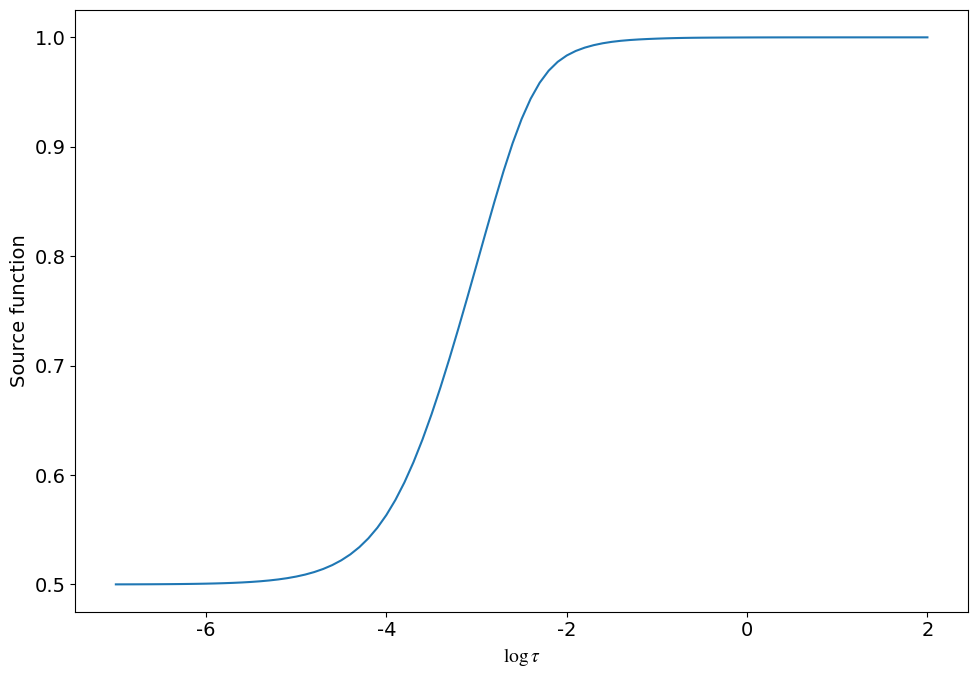

In [11]:
# Set the boundary conditions
I_boundary_lower = B[-1]
I_boundary_upper = 0.0
S = np.copy(B)

# Initialize scattering integral
J = np.zeros(ND)

# Solve RTE for all frequencies in all directions

# For each direction and wavelength, calculate monochromatic intensity and add its contribution to the scattering integral
for m in range(0, NM):
    for l in range(0, NL):
        #print(m)
        # outward
        I = sc_2nd_order(tau * profile[l] * lratio, S, mu[m], B[-1])[0]

        J = J + I * profile[l] * wx[l] * wmu[m] * 0.5

        # inward

        I = sc_2nd_order(tau * profile[l] * lratio, S, -mu[m], 0)[0]

        J = J + I * profile[l] * wx[l] * wmu[m] * 0.5

S = eps * B + (1. - eps) * J

plt.figure(figsize=[10,7])
plt.plot(logtau, S)
plt.xlabel("$\\log\\tau$")
plt.ylabel("Source function")
plt.tight_layout()
print(S)

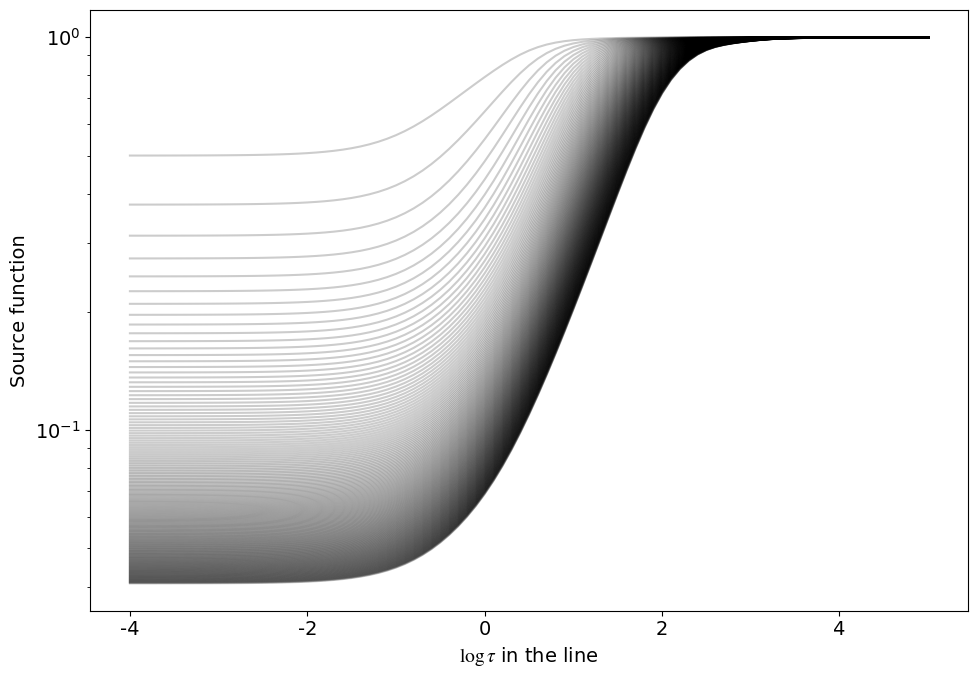

In [12]:
#B = np.zeros(ND)
#B[:] = 1.0
S = np.copy(B)
#print(S)
plt.figure(figsize=[10,7])

for iter in range(0,200):
    # initialize the scattering integral
    J = np.zeros(ND)
    for m in range(0,NM):
        for l in range(0,NL):
            #outward
            I = sc_2nd_order(tau*profile[l]*lratio,S,mu[m],B[-1])[0]
            J+=I*profile[l]*wx[l]*wmu[m]*0.5
            #inward
            I = sc_2nd_order(tau*profile[l]*lratio,S,-mu[m],0)[0]
            J+=I*profile[l]*wx[l]*wmu[m]*0.5
    
    dS = eps * B + (1.-eps)*J - S
    max_change = np.amax(np.abs(dS/S))
    #print (max_change)
    S += dS
    plt.semilogy(logtau+3, S,'-k',alpha=0.2)

plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("Source function")
plt.tight_layout()

<p>
    Now, we want RTE and SE to be consistent (this can be thought of as solving integro-differential equation). Let's solve them in turn many times and see what comes up:
</p>

(21,)


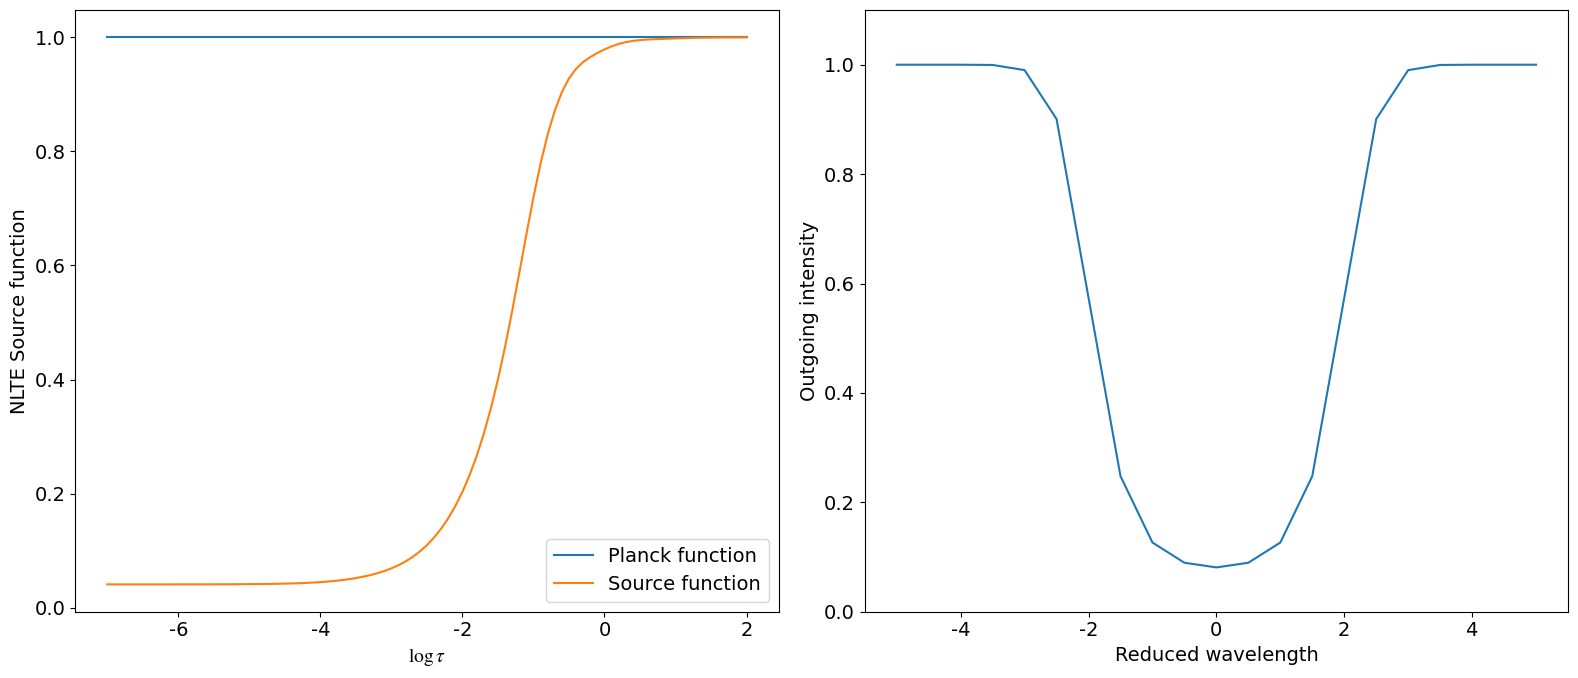

In [13]:
I_out = one_full_fs(tau*lratio,S,1.0,profile,S[-1])
print (I_out.shape)

plt.figure(figsize=[16,7])
plt.subplot(121)
plt.plot(logtau, B,label='Planck function')
plt.plot(logtau, S,label='Source function')
plt.xlabel("$\\log\\tau$")
plt.legend()
plt.ylabel("NLTE Source function")
plt.subplot(122)
plt.plot(x, I_out)
plt.xlabel("Reduced wavelength")
plt.ylabel("Outgoing intensity")
plt.ylim([0,1.1])
plt.tight_layout()

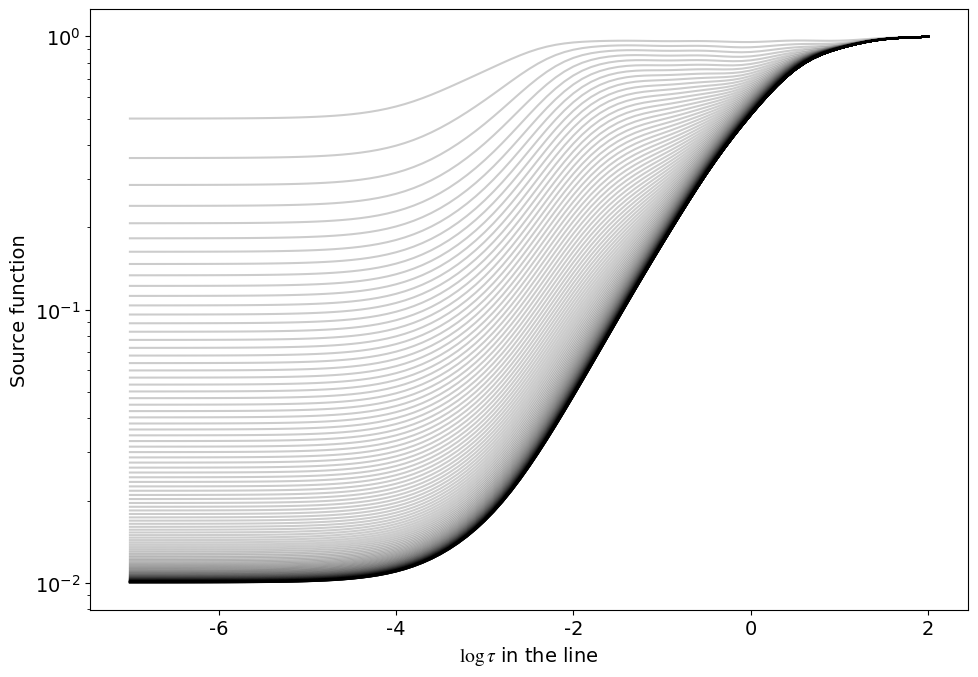

In [14]:
S = np.copy(B)


plt.figure(figsize=[10,7])

for iter in range(0,200):
	
	# Initialize the scattering integral and local lambda operator
	J = np.zeros(ND)
	L = np.zeros(ND)

	# For each direction and wavelength, calculate the specific monochromatic intensity
	# and add contributions to the mean intensity and the local operator
	for m in range(0,NM):
		for l in range(0,NL):

			#outward
			ILambda = sc_2nd_order(tau*profile[l]*lratio,S,mu[m],B[-1])

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5

			#inward
			ILambda = sc_2nd_order(tau*profile[l]*lratio,S,-mu[m],0)

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5
	
	# Correct the source function using local ALI approach:		
	dS = (eps * B + (1.-eps) * J - S) / (1.-(1.-eps)*L)

	# Check for change
	max_change  = np.max(np.abs(dS / S))
	#print (max_change)

	# Correct the source function
	S += dS
	plt.semilogy(logtau,S,'-k',alpha=0.2)
	if (max_change<1E-4):
		break;        
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("Source function")
plt.tight_layout()

<p>NLTE lines are not simple, in addition to RTE we need to solve something that looks like this:</p>
<center>$S = \epsilon B + (1 - \epsilon) \frac{1}{2} \int \int I(\mu, \lambda) \phi_\lambda d\lambda d\mu$</center>
<center>$I = \Lambda_{\lambda, \mu}[S]$</center>
<center>$J = \Lambda'[S]$</center>
<center>$S = \epsilon B + (1 - \epsilon) \Lambda'[S]$</center>
<center>$(1 - (1 - \epsilon)\Lambda')S = \epsilon B$</center>

In [15]:
LL = calc_lambda_full(tau*lratio,mu,wmu,profile,wx)
LL.shape


(91, 91)

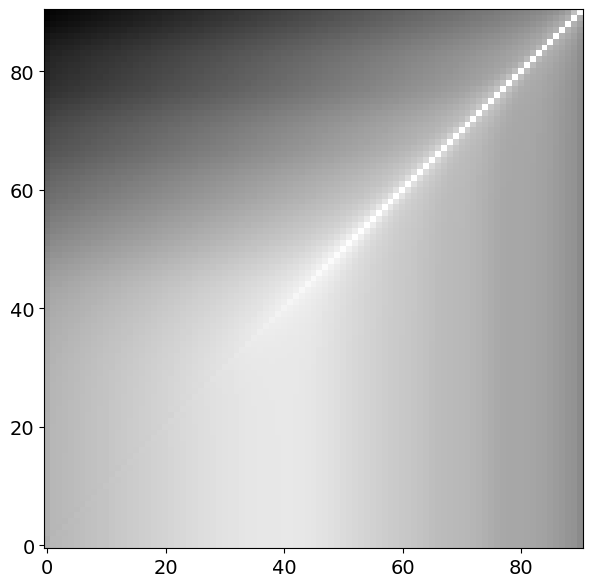

In [16]:
plt.figure(figsize=[10,7])
plt.imshow(np.log10(LL),origin='lower',cmap='gray')

In [17]:
A = (np.eye(ND) - (1.-eps)*LL)
b = eps * B
S = np.linalg.solve(A,b)
S.shape


(91,)

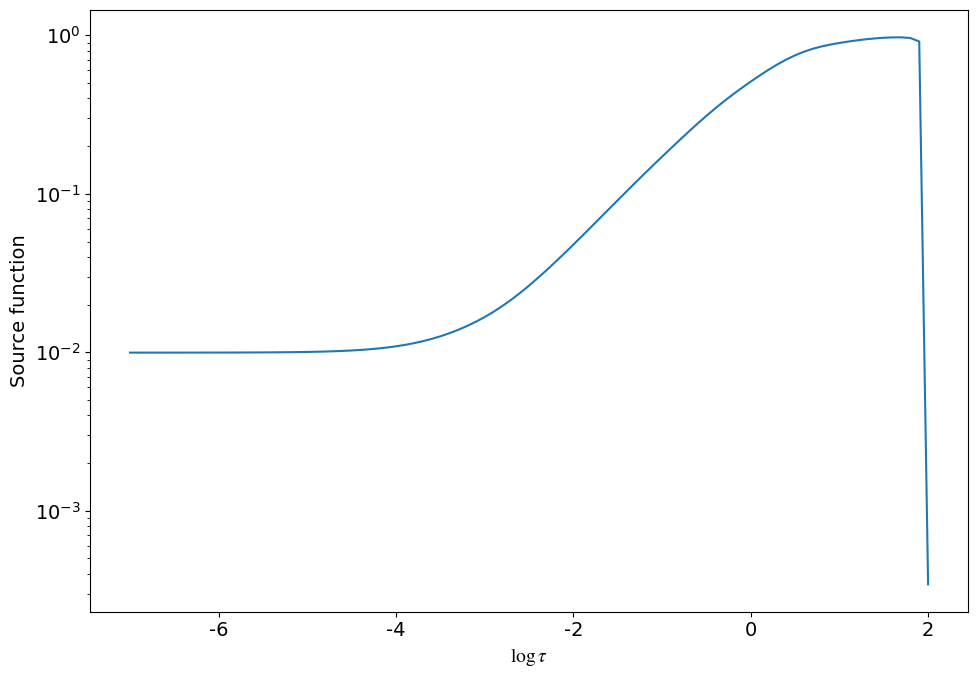

In [18]:
plt.figure(figsize=[10,7])
plt.semilogy(logtau, S)
plt.xlabel("$\\log\\tau$")
plt.ylabel("Source function")
plt.tight_layout()


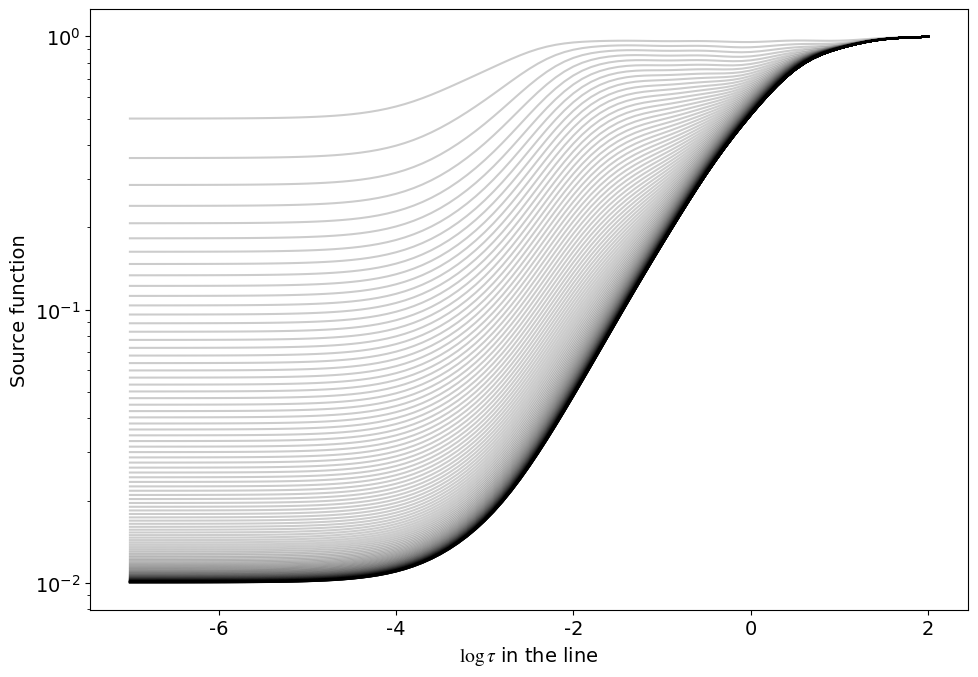

In [19]:
S = np.copy(B)


plt.figure(figsize=[10,7])

for iter in range(0,200):
	
	# Initialize the scattering integral and local lambda operator
	J = np.zeros(ND)
	L = np.zeros(ND)

	# For each direction and wavelength, calculate the specific monochromatic intensity
	# and add contributions to the mean intensity and the local operator
	for m in range(0,NM):
		for l in range(0,NL):

			#outward
			ILambda = sc_2nd_order(tau*profile[l]*lratio,S,mu[m],B[-1])

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5

			#inward
			ILambda = sc_2nd_order(tau*profile[l]*lratio,S,-mu[m],0)

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5
	
	# Correct the source function using local ALI approach:		
	dS = (eps * B + (1.-eps) * J - S) / (1.-(1.-eps)*L)

	# Check for change
	max_change  = np.max(np.abs(dS / S))
	#print (max_change)

	# Correct the source function
	S += dS
	plt.semilogy(logtau,S,'-k',alpha=0.2)
	if (max_change<1E-4):
		break;        
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("Source function")
plt.tight_layout()


<center>$S = \epsilon B + (1 - \epsilon)(\Lambda - \Lambda^*)[S] + (1 - \epsilon)\Lambda^*[S]$</center>
<center>$(1 - (1 - \epsilon)\Lambda^*)S = \epsilon B  + (1 - \epsilon)(\Lambda - \Lambda^*)[S]$</center>

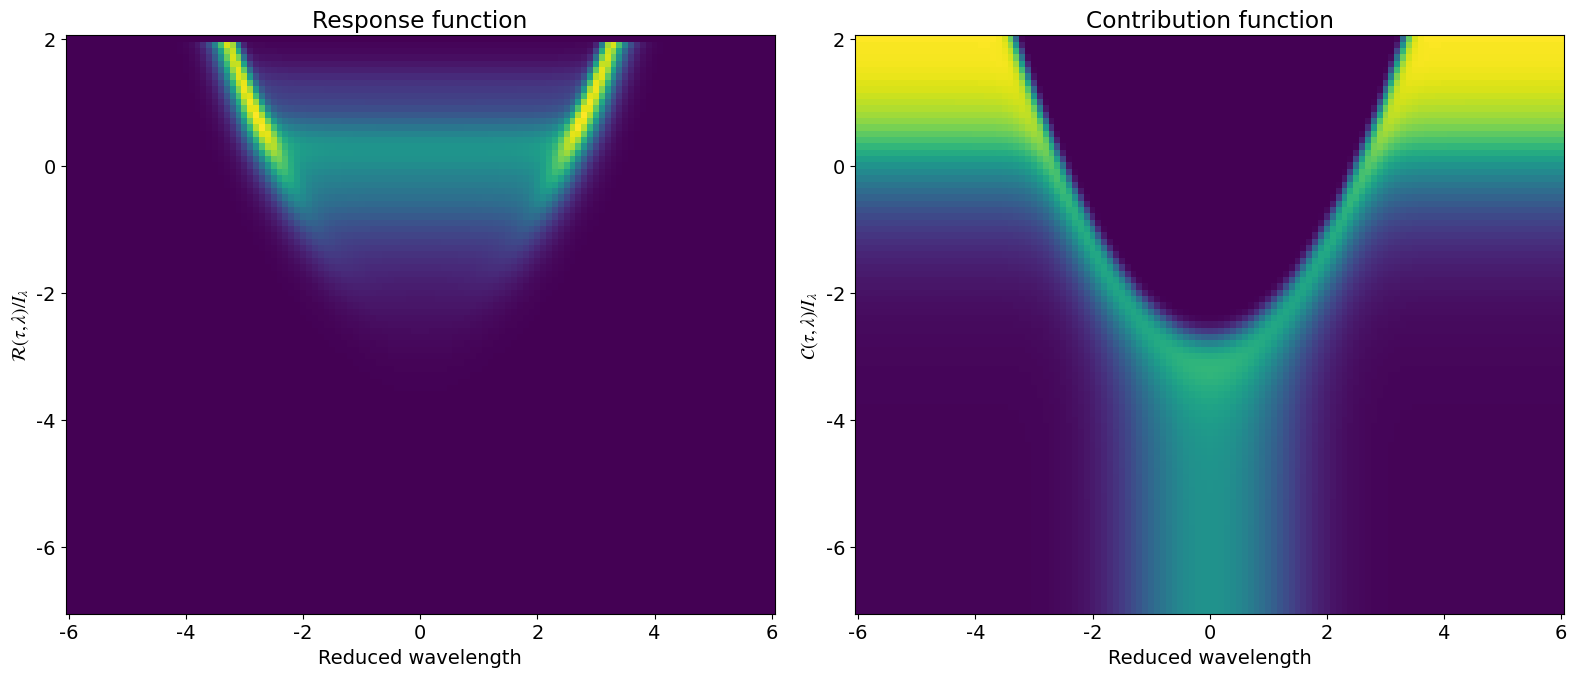

In [20]:
# Calculate the full lambda operator 
LL = calc_lambda_full(tau*lratio,mu,wmu,profile,wx)

# Response function of the source function to the temperature:
dS_dB = np.linalg.inv(np.eye(ND)-(1.-eps)*LL)@ (eps*np.eye(ND))

# Then the emergent intensity is:
# We use more refined profile to get a nicer-looking line
x_detailed = np.linspace(-6,6,121)
detailed_profile = 1./np.sqrt(np.pi) * np.exp(-x_detailed**2.0)

# Spectra is result of one formal solution in direction mu = 1
spectra = one_full_fs(tau*lratio,S,1.0,detailed_profile,B[-1])

# Response function of the intensity we will calculate by perturbing the source function
# at each depth by the response we just calculated and then subtracting the original one
rf = np.zeros((ND,detailed_profile.shape[0]))
for d in range(0,ND):
	rf[d] = one_full_fs(tau*lratio,S+dS_dB[:,d]*1E-3,1.0,detailed_profile,B[-1])-spectra

CF = np.zeros((ND,detailed_profile.shape[0]))

for l in range(0,detailed_profile.shape[0]):
	CF[:,l] = S * np.exp(-tau*lratio*detailed_profile[l] * tau*lratio*detailed_profile[l])

#plot the results.
plt.figure(figsize=[16,7])
#plt.clf()
#plt.cla()
plt.subplot(121)
plt.pcolormesh(x_detailed,np.log10(tau),rf/spectra)
plt.xlabel("Reduced wavelength")
plt.ylabel("$\\mathcal{R}(\\tau,\lambda)/I_\lambda$")
plt.title("Response function")
plt.subplot(122)
plt.pcolormesh(x_detailed,np.log10(tau),CF/spectra)
plt.xlabel("Reduced wavelength")
plt.ylabel("$\\mathcal{C}(\\tau,\lambda)/I_\lambda$")
plt.title("Contribution function")
plt.tight_layout()
#plt.savefig("2LVL_NLTE_RF_vs_CF.png",fmt='png',bbox_inches='tight')


<h2>20. 06. 2025.</h2>
<p>
    Our first task is to re-create <b>Fig 11.1</b> from Mihalas 1978, 2nd Edition: Line source function in a semi-infinite
    atmosphere with B = 1, for a line with a pure Doppler profile (<i>a</i> = 0), and various values of $\varepsilon$.
</p>

<h3>Brief background</h3>
<p>
    Numerical solutions for the full depth-variation of $S_l(\tau)$ for semi-infinite atmosphere, constant Planck
    function (B = 1), a Doppler profile ($a$ = 0) and various value of $\varepsilon$ should yield this:
</p>
<center>$S_l(0) = \sqrt{\varepsilon} \cdot B$</center>

<p>where $S_l(0)$ is frequency-independent source function at surface. This result is independent of the quadrature sum and
the form of the profile, and hence is general.</p>

In [21]:
nd = 91
logtau_Mihalas = np.linspace(-5, 10, nd)
tau_M = 10**logtau_Mihalas

# We will assume isothermal atmosphere as case scenario, hence define Planck's function
B = np.zeros(nd)
B[:] = 1.0

In [22]:
# Weights for wavelength 
NL = 21
x = np.linspace(-5, 5, NL)
profile = 1./np.sqrt(np.pi) * np.exp(-(x**2.0)) # Doppler profile
wx = np.zeros(NL)

wx[0] = (x[1] - x[0]) * 0.5
wx[-1] = (x[-1] - x[-2]) * 0.5
wx[1:-1] = (x[2:NL] - x[0:-2]) * 0.5
norm = (np.sum(profile*wx))
wx = wx/norm

# Angle integration:
mu=([1./np.sqrt(3.0)])
wmu=[1.0]
mu=np.cos([0.4793425352,1.0471975512,1.4578547042])
wmu=[.2777777778,0.4444444444,0.2777777778]
NM = mu.shape[0]
mu = np.asarray(mu)
wmu = np.asarray(wmu)

In [23]:
# Photon destruction probability (the lower this value is, the more NLTE the case is)

epsilon = np.zeros((5, nd))
epsilon[0, :] = 1E-2
epsilon[1, :] = 1E-4
epsilon[2, :] = 1E-6
epsilon[3, :] = 1E-8
epsilon[4, :] = 1E-10


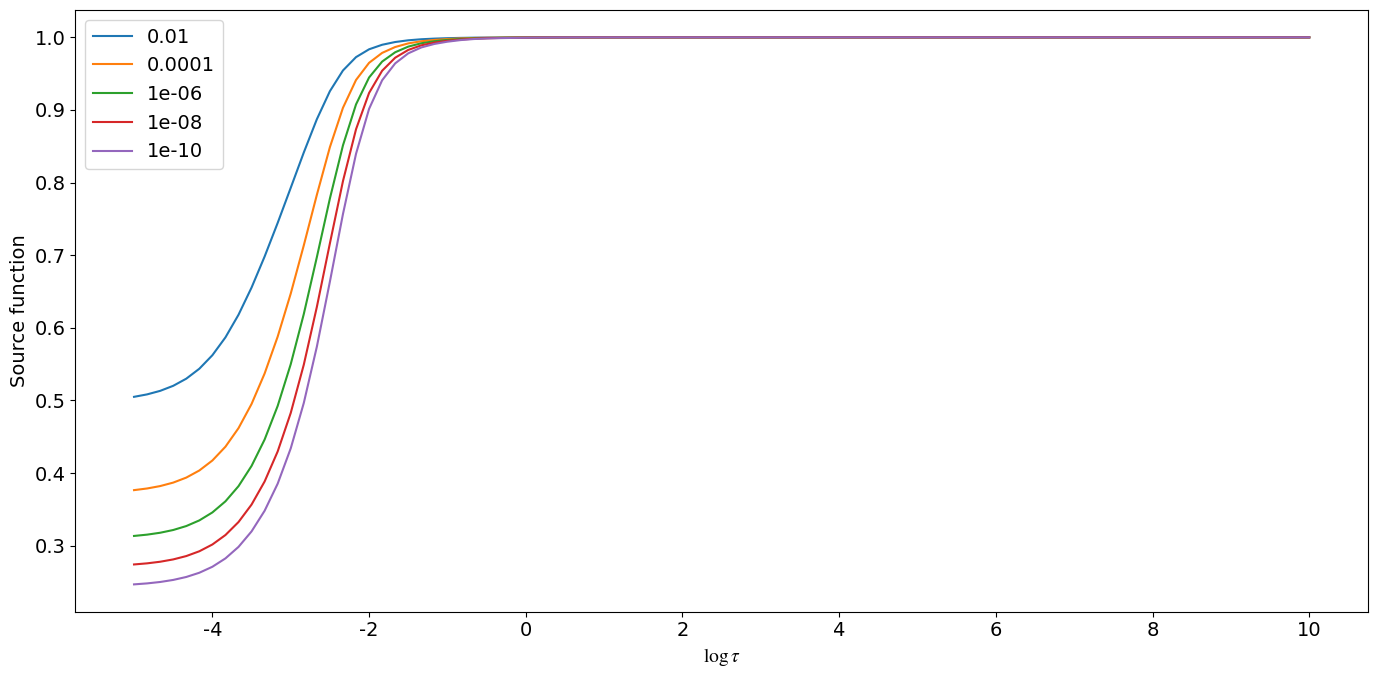

In [24]:
I_boundary_lower = B[-1]
I_boundary_upper = 0.0
S = np.copy(B)
S_ = np.zeros((5, nd))
# Initialize scattering integral
#J = np.zeros(nd)
plt.figure(figsize=[14,7])
# Solve RTE for all frequencies in all directions

# For each direction and wavelength, calculate monochromatic intensity and add its contribution to the scattering integral

for e in range(0, 5):
    J = np.zeros(nd)
    L = np.zeros(nd)
    for m in range(0, NM):
        for l in range(0, NL):
            I = sc_2nd_order(tau_M * profile[l] * lratio , S, mu[m], B[-1])

            J = J + I[0] * profile[l] * wx[l] * wmu[m] * 0.5

            L = L + I[1] * profile[l] * wx[l] * wmu[m] * 0.5

            I = sc_2nd_order(tau_M * profile[l] * lratio, S, -mu[m], 0)

            J = J + I[0] * profile[l] * wx[l] * wmu[m] * 0.5

            L = L + I[1] * profile[l] * wx[l] * wmu[m] * 0.5
            
    #dS = (epsilon[e] * B + (1.-epsilon[e])*J - S)/(1.-(1.-epsilon[e])*L)
    S = epsilon[e] * B + (1. - epsilon[e]) * J
    #S_[e] = S_[e] + dS
    S_[e] = S
    plt.plot(logtau_Mihalas, S_[e], label = epsilon[e,l] )
    #plt.plot(logtau_Mihalas, np.sqrt(epsilon[e]) * B, color='r', linestyle='--', label='$\sqrt{\\varepsilon}B$')
    #plt.semilogy(logtau_Mihalas,S_[e],'-k',alpha=0.2)

plt.xlabel("$\\log\\tau$")
plt.ylabel("Source function")
plt.legend()
plt.tight_layout()

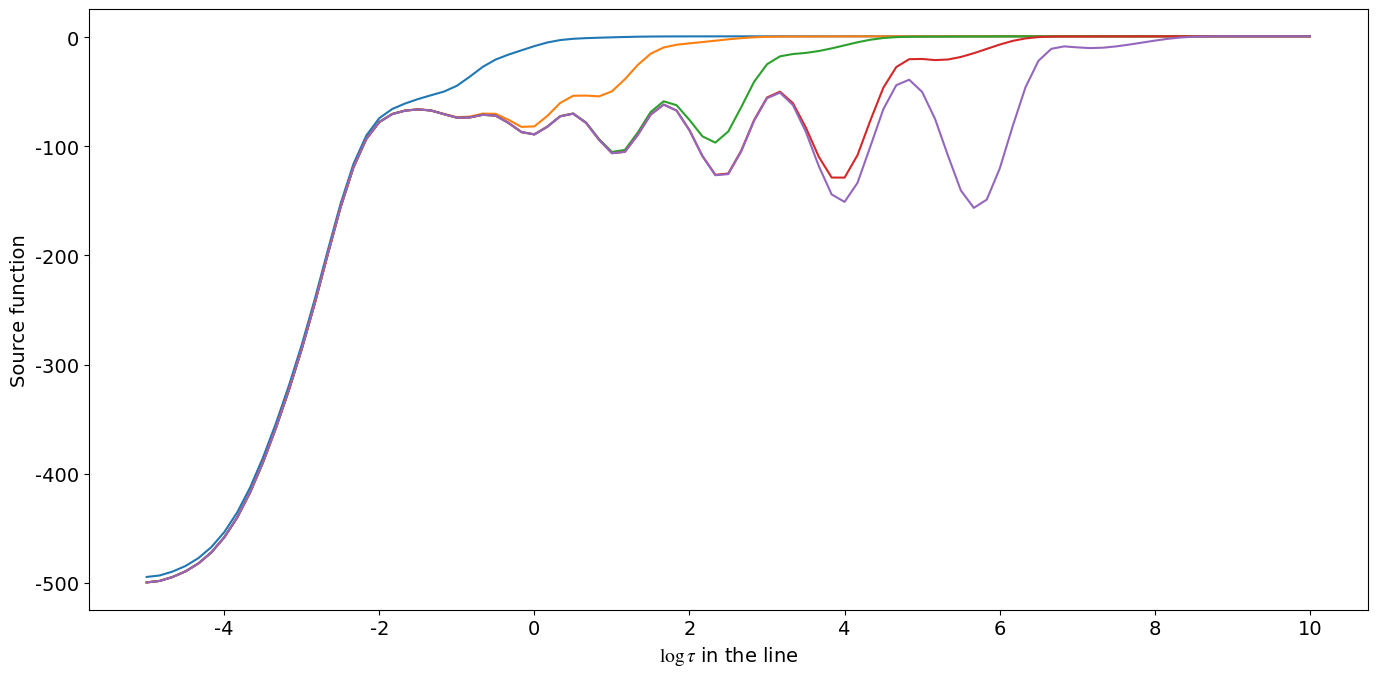

In [25]:
I_boundary_lower = B[-1]
I_boundary_upper = 0.0
S = np.copy(B)
S_ = np.zeros((5, nd))
# Initialize scattering integral
#J = np.zeros(nd)
plt.figure(figsize=[14,7])
S_2 = np.copy(B)
S_4 = np.copy(B)
S_6 = np.copy(B)
S_8 = np.copy(B)
S_10 = np.copy(B)
# Solve RTE for all frequencies in all directions
for e in range(0, 5):
    for iter in range(0, 200):
        J = np.zeros(nd)
        L = np.zeros(nd)
        for m in range(0, NM):
            for l in range(0, NL):
                # outward
                ILambda = sc_2nd_order(tau_M * profile[l] * lratio , S, mu[m], B[-1])

                J = J + ILambda[0] * profile[l] * wx[l] * wmu[m] * 0.5

                L = L + ILambda[1] * profile[l] * wx[l] * wmu[m] * 0.5

                # inward

                ILambda = sc_2nd_order(tau_M * profile[l] * lratio, S, -mu[m], 0)

                J = J + ILambda[0] * profile[l] * wx[l] * wmu[m] * 0.5

                L = L + ILambda[1] * profile[l] * wx[l] * wmu[m] * 0.5

        dS2 = (epsilon[0] * B + (1.-epsilon[0]) * J - S) / (1.-(1.-epsilon[0])*L)
        dS4 = (epsilon[1] * B + (1.-epsilon[1]) * J - S) / (1.-(1.-epsilon[1])*L)
        dS6 = (epsilon[2] * B + (1.-epsilon[2]) * J - S) / (1.-(1.-epsilon[2])*L)
        dS8 = (epsilon[3] * B + (1.-epsilon[3]) * J - S) / (1.-(1.-epsilon[3])*L)
        dS10 = (epsilon[4] * B + (1.-epsilon[4]) * J - S) / (1.-(1.-epsilon[4])*L)

        S_2 += dS2
        S_4 += dS4
        S_6 += dS6
        S_8 += dS8
        S_10 += dS10

plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("Source function")
plt.plot(logtau_Mihalas, S_2)
plt.plot(logtau_Mihalas, S_4)
plt.plot(logtau_Mihalas, S_6)
plt.plot(logtau_Mihalas, S_8)
plt.plot(logtau_Mihalas, S_10)
plt.tight_layout()

(5, 91)


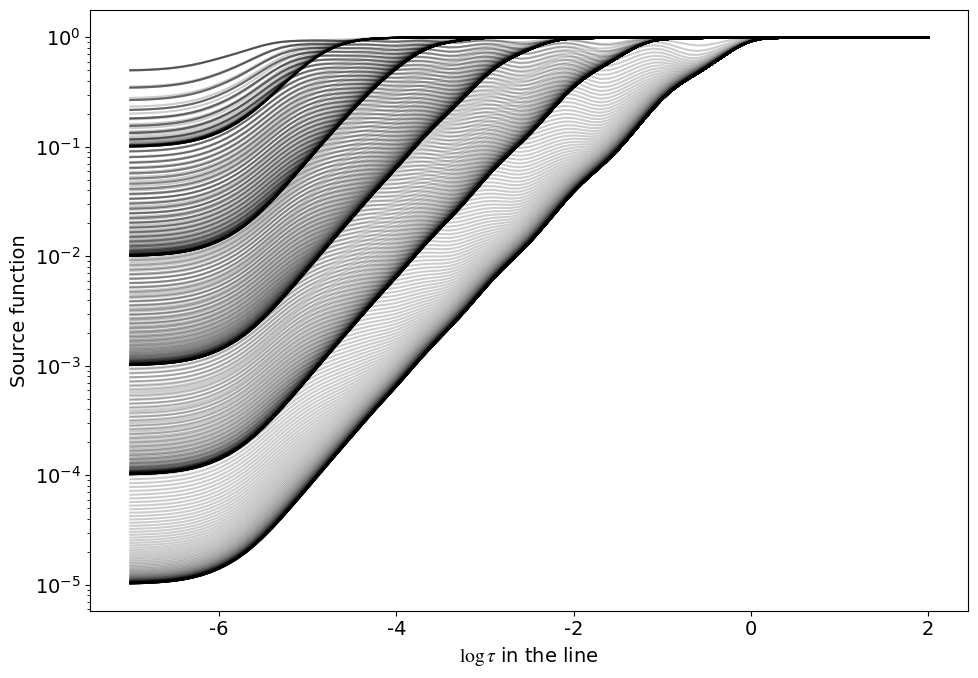

In [26]:
logS = np.zeros((5, nd))
plt.figure(figsize=[10,7])

eps = np.zeros(nd)
eps[:] = 1E-2
S = np.copy(B)

for iter in range(0,200):
	
	# Initialize the scattering integral and local lambda operator
	J = np.zeros(ND)
	L = np.zeros(ND)

	# For each direction and wavelength, calculate the specific monochromatic intensity
	# and add contributions to the mean intensity and the local operator
	for m in range(0,NM):
		for l in range(0,NL):

			#outward
			ILambda = sc_2nd_order(tau_M*profile[l]*lratio,S,mu[m],B[-1])

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5

			#inward
			ILambda = sc_2nd_order(tau_M*profile[l]*lratio,S,-mu[m],0)

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5
	
	# Correct the source function using local ALI approach:		
	dS = (eps * B + (1.-eps) * J - S) / (1.-(1.-eps)*L)

	# Check for change
	max_change  = np.max(np.abs(dS / S))
	#print (max_change)

	# Correct the source function
	S += dS
	plt.semilogy(logtau,S,'-k',alpha=0.2)
	if (max_change<1E-4):
		break;        
logS[0,:] = S

eps = np.zeros(nd)
eps[:] = 1E-4
S = np.copy(B)

for iter in range(0,200):
	
	# Initialize the scattering integral and local lambda operator
	J = np.zeros(ND)
	L = np.zeros(ND)

	# For each direction and wavelength, calculate the specific monochromatic intensity
	# and add contributions to the mean intensity and the local operator
	for m in range(0,NM):
		for l in range(0,NL):

			#outward
			ILambda = sc_2nd_order(tau_M*profile[l]*lratio,S,mu[m],B[-1])

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5

			#inward
			ILambda = sc_2nd_order(tau_M*profile[l]*lratio,S,-mu[m],0)

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5
	
	# Correct the source function using local ALI approach:		
	dS = (eps * B + (1.-eps) * J - S) / (1.-(1.-eps)*L)

	# Check for change
	max_change  = np.max(np.abs(dS / S))
	#print (max_change)

	# Correct the source function
	S += dS
	plt.semilogy(logtau,S,'-k',alpha=0.2)
	if (max_change<1E-4):
		break;        
logS[1,:] = S

eps = np.zeros(nd)
eps[:] = 1E-6
S = np.copy(B)

for iter in range(0,200):
	
	# Initialize the scattering integral and local lambda operator
	J = np.zeros(ND)
	L = np.zeros(ND)

	# For each direction and wavelength, calculate the specific monochromatic intensity
	# and add contributions to the mean intensity and the local operator
	for m in range(0,NM):
		for l in range(0,NL):

			#outward
			ILambda = sc_2nd_order(tau_M*profile[l]*lratio,S,mu[m],B[-1])

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5

			#inward
			ILambda = sc_2nd_order(tau_M*profile[l]*lratio,S,-mu[m],0)

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5
	
	# Correct the source function using local ALI approach:		
	dS = (eps * B + (1.-eps) * J - S) / (1.-(1.-eps)*L)

	# Check for change
	max_change  = np.max(np.abs(dS / S))
	#print (max_change)

	# Correct the source function
	S += dS
	plt.semilogy(logtau,S,'-k',alpha=0.2)
	if (max_change<1E-4):
		break;        
logS[2, :] = S

eps = np.zeros(nd)
eps[:] = 1E-8
S = np.copy(B)

for iter in range(0,200):
	
	# Initialize the scattering integral and local lambda operator
	J = np.zeros(ND)
	L = np.zeros(ND)

	# For each direction and wavelength, calculate the specific monochromatic intensity
	# and add contributions to the mean intensity and the local operator
	for m in range(0,NM):
		for l in range(0,NL):

			#outward
			ILambda = sc_2nd_order(tau_M*profile[l]*lratio,S,mu[m],B[-1])

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5

			#inward
			ILambda = sc_2nd_order(tau_M*profile[l]*lratio,S,-mu[m],0)

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5
	
	# Correct the source function using local ALI approach:		
	dS = (eps * B + (1.-eps) * J - S) / (1.-(1.-eps)*L)

	# Check for change
	max_change  = np.max(np.abs(dS / S))
	#print (max_change)

	# Correct the source function
	S += dS
	plt.semilogy(logtau,S,'-k',alpha=0.2)
	if (max_change<1E-4):
		break;        
logS[3, :] = S

eps = np.zeros(nd)
eps[:] = 1E-10
S = np.copy(B)

for iter in range(0,200):
	
	# Initialize the scattering integral and local lambda operator
	J = np.zeros(ND)
	L = np.zeros(ND)

	# For each direction and wavelength, calculate the specific monochromatic intensity
	# and add contributions to the mean intensity and the local operator
	for m in range(0,NM):
		for l in range(0,NL):

			#outward
			ILambda = sc_2nd_order(tau_M*profile[l]*lratio,S,mu[m],B[-1])

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5

			#inward
			ILambda = sc_2nd_order(tau_M*profile[l]*lratio,S,-mu[m],0)

			J+=ILambda[0]*profile[l]*wx[l]*wmu[m]*0.5
			L+=ILambda[1]*profile[l]*wx[l]*wmu[m]*0.5
	
	# Correct the source function using local ALI approach:		
	dS = (eps * B + (1.-eps) * J - S) / (1.-(1.-eps)*L)

	# Check for change
	max_change  = np.max(np.abs(dS / S))
	#print (max_change)

	# Correct the source function
	S += dS
	plt.semilogy(logtau,S,'-k',alpha=0.2)
	if (max_change<1E-4):
		break;        
logS[4, :] = S
#print(logS)

print(np.shape(logS))
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("Source function")
#plt.plot(logtau_Mihalas, S[0])
plt.tight_layout()

/tmp/ipykernel_22497/763958564.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


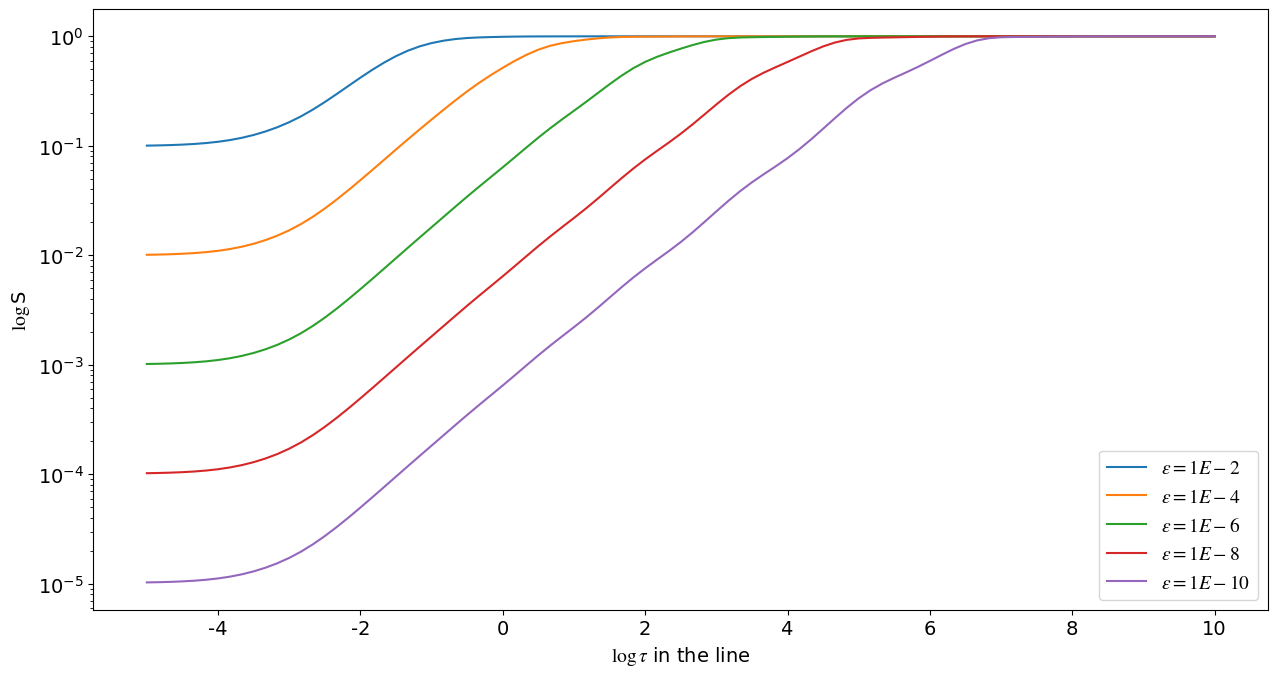

In [27]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("$\\log$S")
plt.semilogy(logtau_Mihalas, logS[0], label = "$\\varepsilon = 1E-2$")
plt.semilogy(logtau_Mihalas, logS[1], label = "$\\varepsilon = 1E-4$")
plt.semilogy(logtau_Mihalas, logS[2], label = "$\\varepsilon = 1E-6$")
plt.semilogy(logtau_Mihalas, logS[3], label = "$\\varepsilon = 1E-8$")
plt.semilogy(logtau_Mihalas, logS[4], label = "$\\varepsilon = 1E-10$")
plt.tight_layout()
plt.legend()

In [28]:
# Kreirati funkciju koja resava non-LTE problem za dati model atmosfere.
# Model atmosfere je niz sa odredjenim brojem dubinama koja prima B, epsilon i eventualno profil.
# Unaprediti funkciju za finite slabs (izvor zracenja unutar njih) slucaj.
# Kako bismo resili problem ako finite slab ne emituje samo sam po sebi, nego postoji i spoljni izvor zracenja koji
# ga obasjava!?
from scipy.special import wofz
def solve_2level_nlte(ND, NM, NL, B, profile_type, line_ratio = 1E3):
    # ND - number of points for depth/optical depth grid
    # NM - number of points for angle grid
    # NL - number of points for wavelength/frequency grid
    # epsilon - photon probability destruction
    # B - Planck's function
    # profile_type - spectral line profile (Doppler, Voigt or Lorentz)
    # line_ratio (default = 1E3 for us) is the line and continuum opacity ratio
    
    # Optical depth grid
    logtau = np.linspace(-5, 10, ND)
    tau = 10**logtau

    # Planck's function
    B = np.zeros(ND)
    B[:] = 1 # constant with depth (simplified case)
    #print(B)
    
    # Photon probablity destruction
    epsilon = np.zeros(ND)
    epsilon[:] = float(input("Please enter the value for photon destruction probability: ")) # change to suit your needs

    # Reduced wavlength in Doppler widths
    x = np.linspace(-5, 5, NL)
    #print(x)
    
    if (profile_type == 1):
        # Doppler profile
        profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))
    elif profile_type == 2:
        # Voigt profile
        alpha = float(input("Please enter the value for alpha: "))
        gamma = float(input("Please enter the value for gamma: "))
        sigma = alpha / np.sqrt(2 * np.log(2))
        profile = np.real(wofz((x + 1j * gamma) / sigma / np.sqrt(2)))/sigma/np.sqrt(2 * np.pi)
    elif profile_type == 3:
        # Lorentz profile
        profile = 1/np.pi * (1 + x**2)
    else:
        print("Profile type must be 1, 2 or 3")

    wx = np.zeros(NL)

    wx[0] = (x[1] - x[0]) * 0.5
    wx[-1] = (x[-1] - x[-2]) * 0.5
    wx[1:-1] = (x[2:NL] - x[0:-2]) * 0.5
    norm = (np.sum(profile*wx))
    wx = wx/norm
    
    # Angle integration:
    mu=([1./np.sqrt(3.0)])
    wmu=[1.0]
    mu=np.cos([0.4793425352,1.0471975512,1.4578547042])
    wmu=[.2777777778,0.4444444444,0.2777777778]
    NM = mu.shape[0]
    mu = np.asarray(mu)
    wmu = np.asarray(wmu)
    #print(wmu)
    #print(profile)
    #print(mu)
    # Initialize one figure for plotting
    fig = plt.figure(constrained_layout = True, figsize = (13, 7))

    # Solve radiative transfer equation (first by using Ivan's functions)
    S = np.copy(B) # the source function 
    #print(S)
    # We will iterate 'till the convergence
    for j in range(0, 1000):
        J = np.zeros(ND) # initialize the scattering integral
        L = np.zeros(ND) # initialize the Lambda operator
        # For each direction and wavelength, calculate monochromatic intensity and add its contribution to the scattering integral
        for m in range(0, NM):
            for l in range(0, NL):

                # outward

                I_Lambda = sc_2nd_order(tau * profile[l] * lratio, S, mu[m], B[-1])

                J = J + I_Lambda[0] * profile[l] * wx[l] * wmu[m] * 0.5

                L = L + I_Lambda[1] * profile[l] * wx[l] * wmu[m] * 0.5

                # inward

                I_Lambda = sc_2nd_order(tau * profile[l] * lratio, S, -mu[m], 0)

                J = J + I_Lambda[0] * profile[l] * wx[l] * wmu[m] * 0.5

                L = L + I_Lambda[1] * profile[l] * wx[l] * wmu[m] * 0.5

        # Correct the source function using the local ALI approach
        dS = (epsilon * B + (1. - epsilon) * J - S)/(1. - (1. - epsilon) * L)

        # Check for change
        max_change = np.max(np.abs(dS/S))

        S += dS
        plt.semilogy(logtau, S, '-k', alpha = 0.20)
        if(max_change < 1E-4):
            break
        fin = S    
    plt.xlabel("$\\log\\tau$ in the line")
    plt.ylabel("$\\log$S")
    #plt.tight_layout()
    return fin

Please enter the value for photon destruction probability:  1E-2


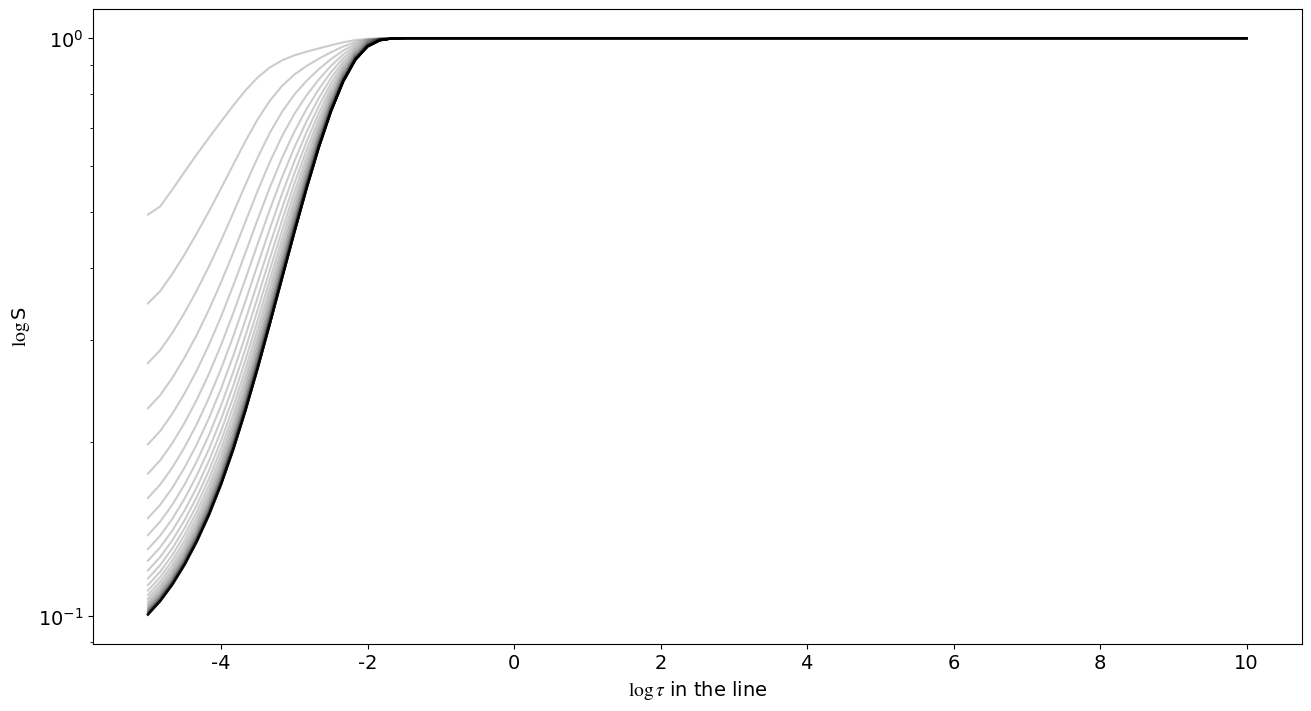

In [29]:
S_Lorentz = solve_2level_nlte(91, 3, 21, 1.0, 3)

Please enter the value for photon destruction probability:  1E-2
Please enter the value for photon destruction probability:  1E-4
Please enter the value for photon destruction probability:  1E-6
Please enter the value for photon destruction probability:  1E-8
Please enter the value for photon destruction probability:  1E-10


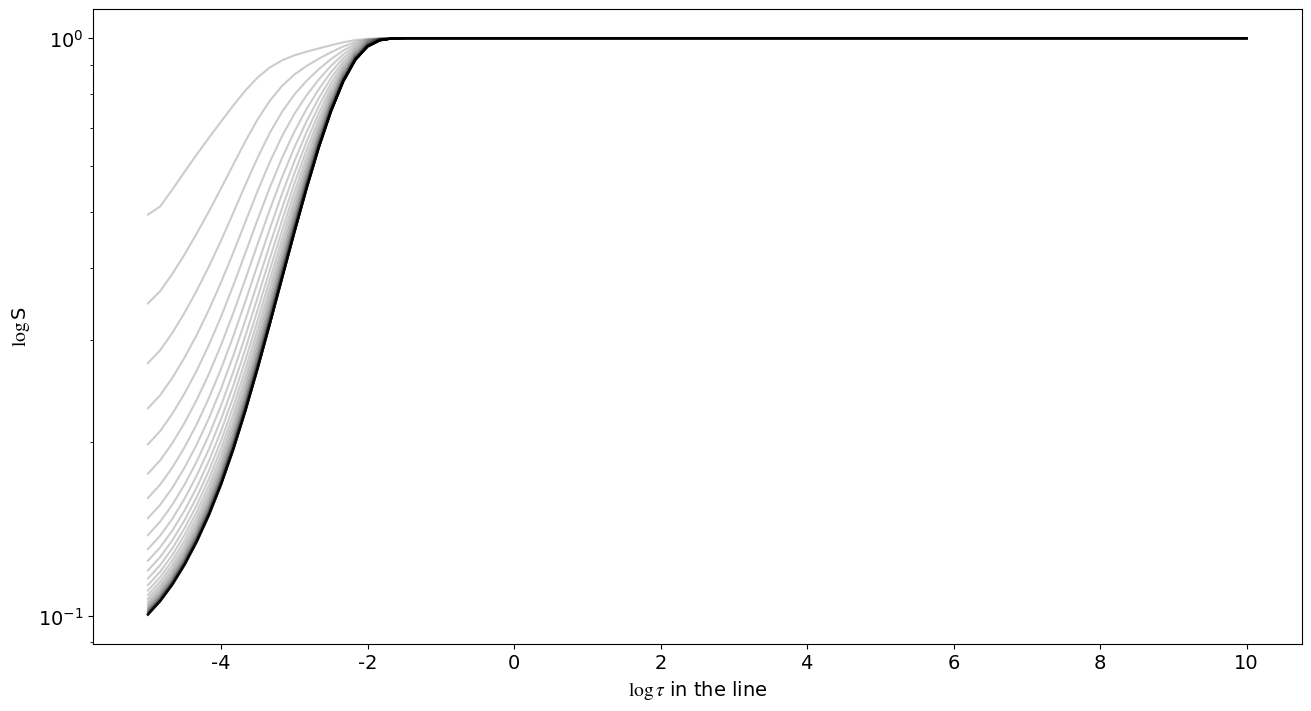

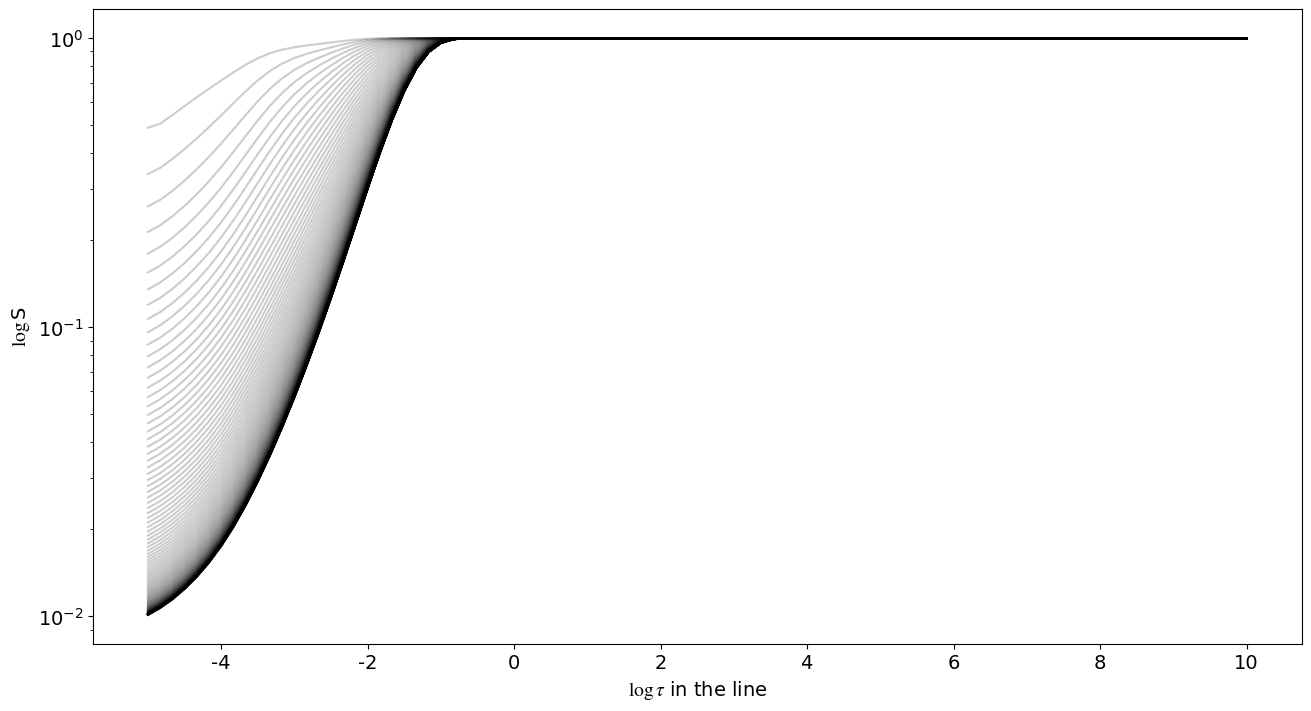

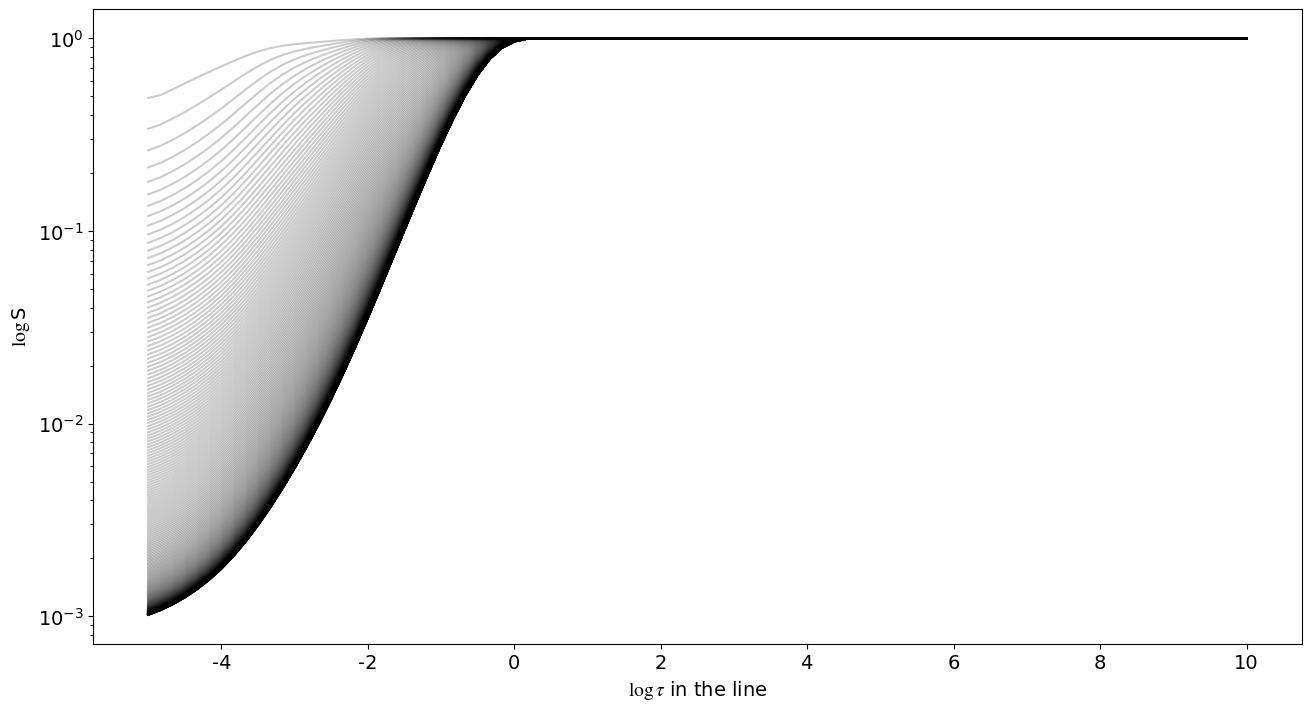

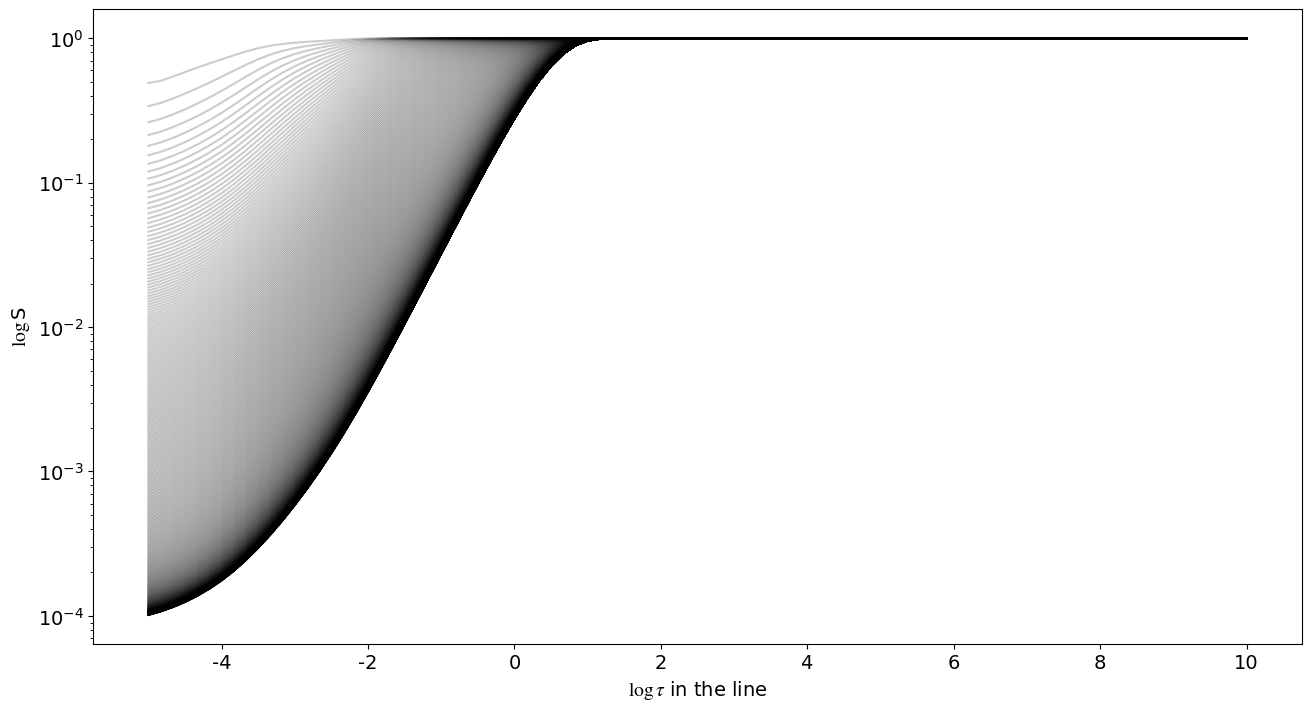

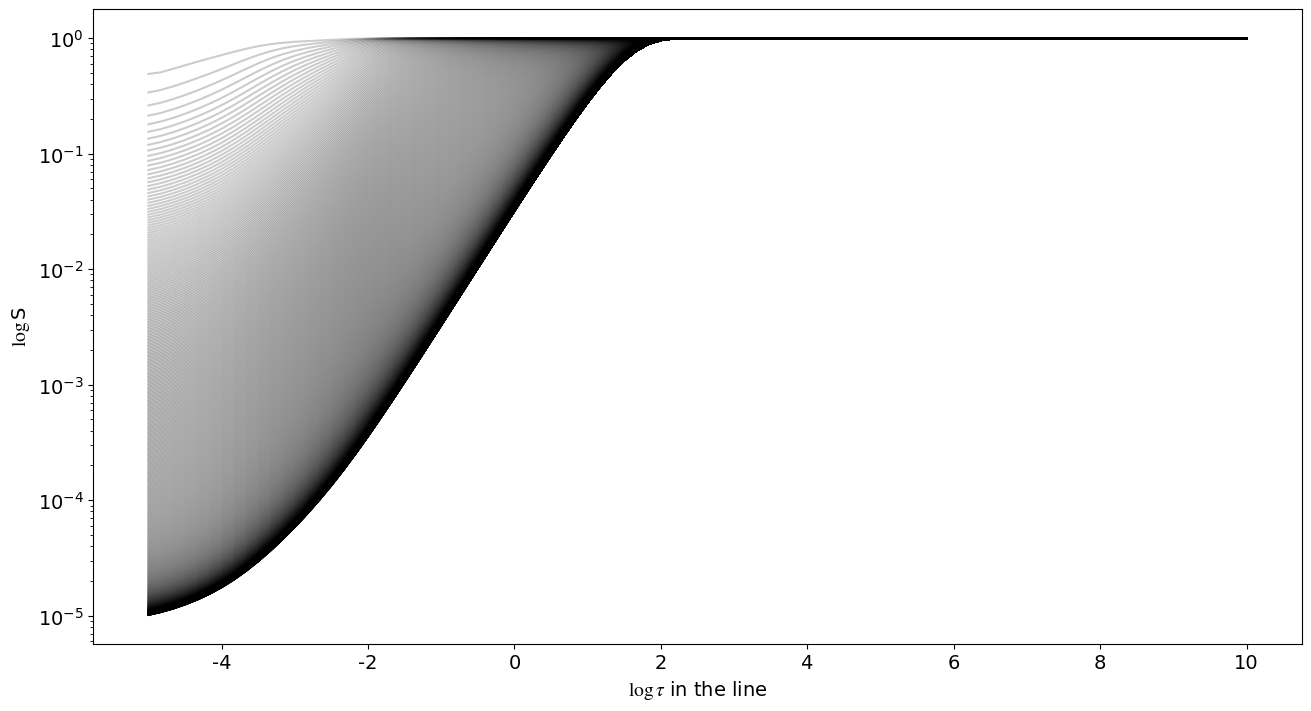

In [30]:
S_Lorentz2 = solve_2level_nlte(91, 3, 21, 1.0, 3)
S_Lorentz4 = solve_2level_nlte(91, 3, 21, 1.0, 3)
S_Lorentz6 = solve_2level_nlte(91, 3, 21, 1.0, 3)
S_Lorentz8 = solve_2level_nlte(91, 3, 21, 1.0, 3)
S_Lorentz10 = solve_2level_nlte(91, 3, 21, 1.0, 3)

Please enter the value for photon destruction probability:  1E-2
Please enter the value for alpha:  0.1
Please enter the value for gamma:  1E-3
Please enter the value for photon destruction probability:  1E-4
Please enter the value for alpha:  0.1
Please enter the value for gamma:  1E-3
Please enter the value for photon destruction probability:  1E-6
Please enter the value for alpha:  0.1
Please enter the value for gamma:  1E-3
Please enter the value for photon destruction probability:  1E-8
Please enter the value for alpha:  0.1
Please enter the value for gamma:  1E-3
Please enter the value for photon destruction probability:  1E-10
Please enter the value for alpha:  0.1
Please enter the value for gamma:  1E-3


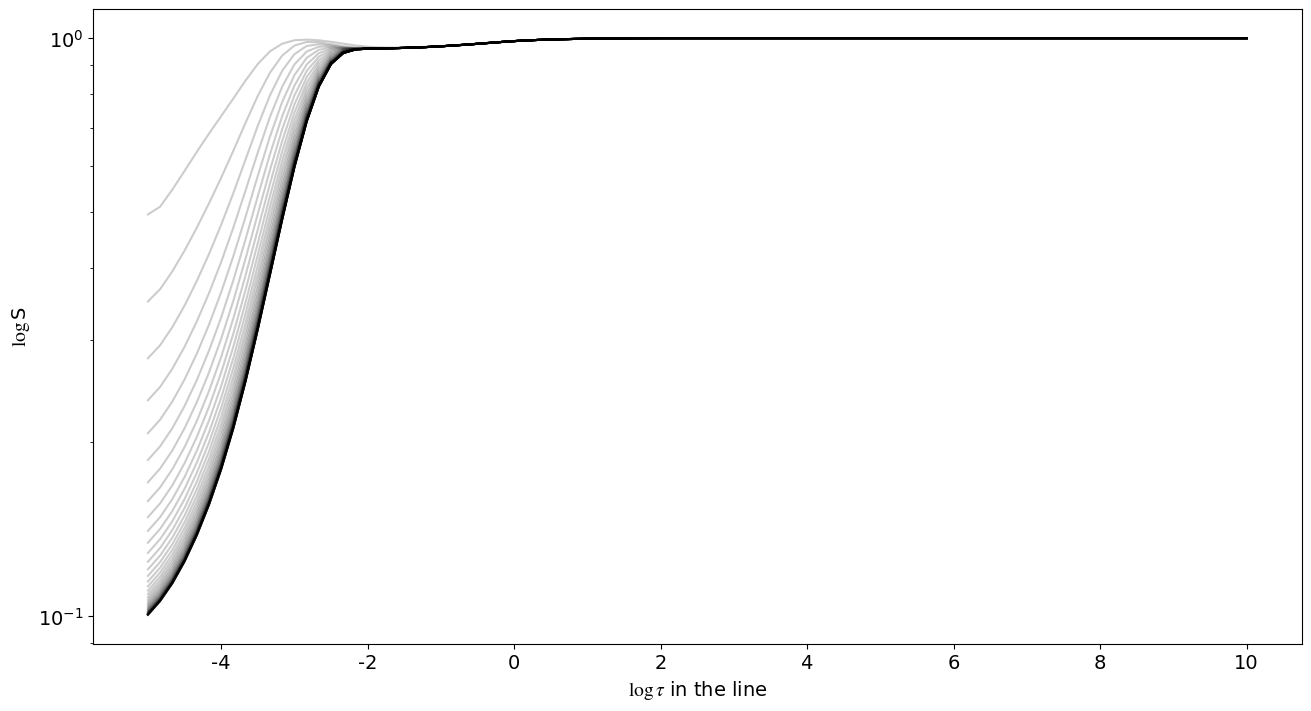

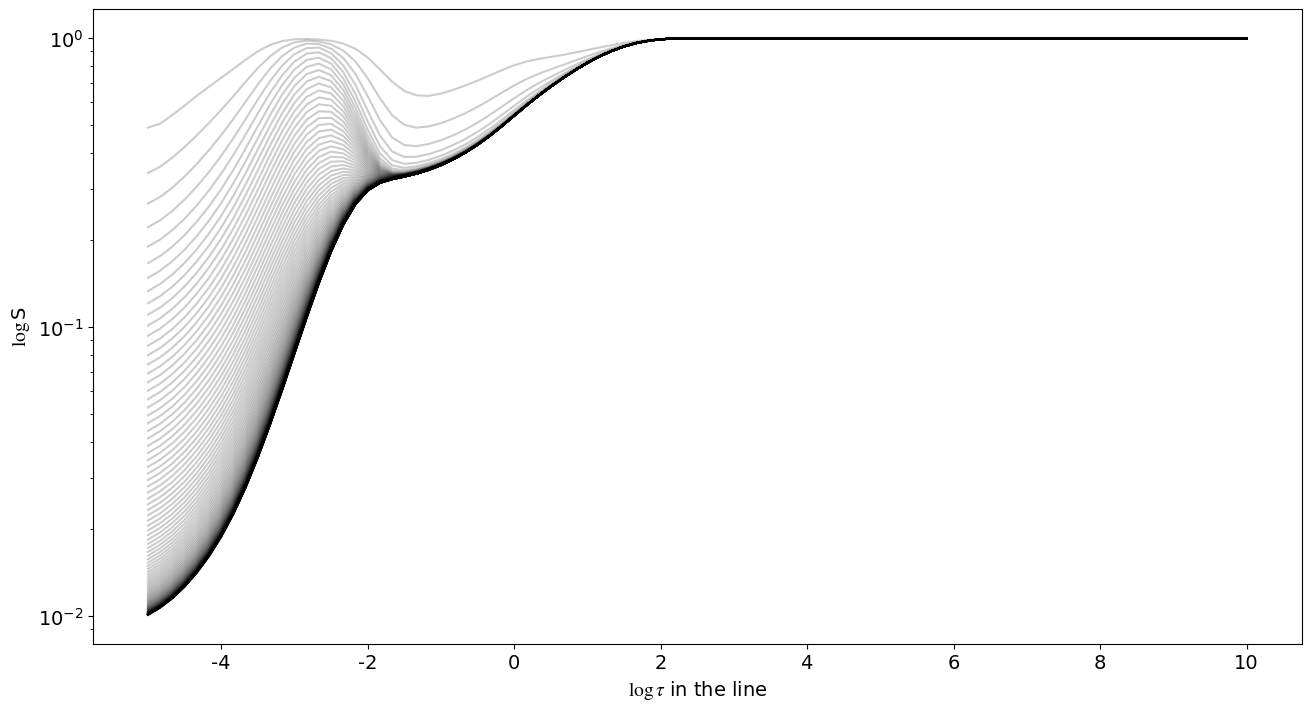

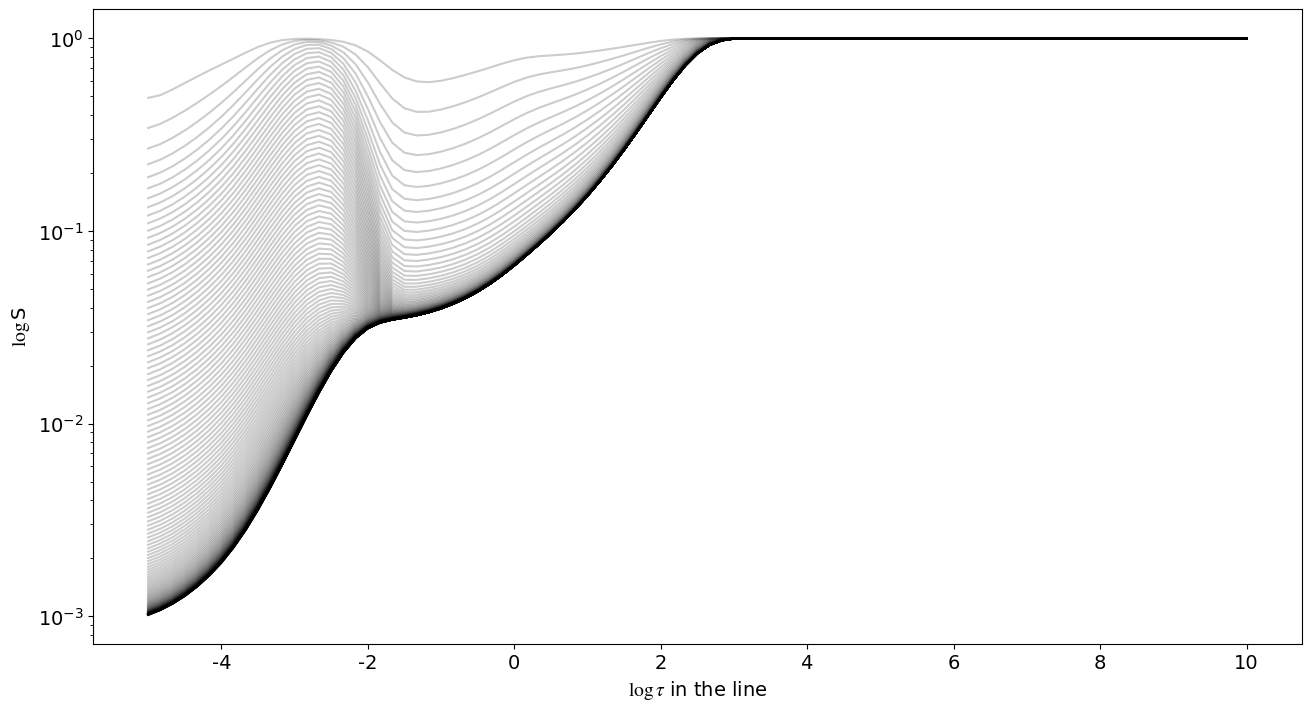

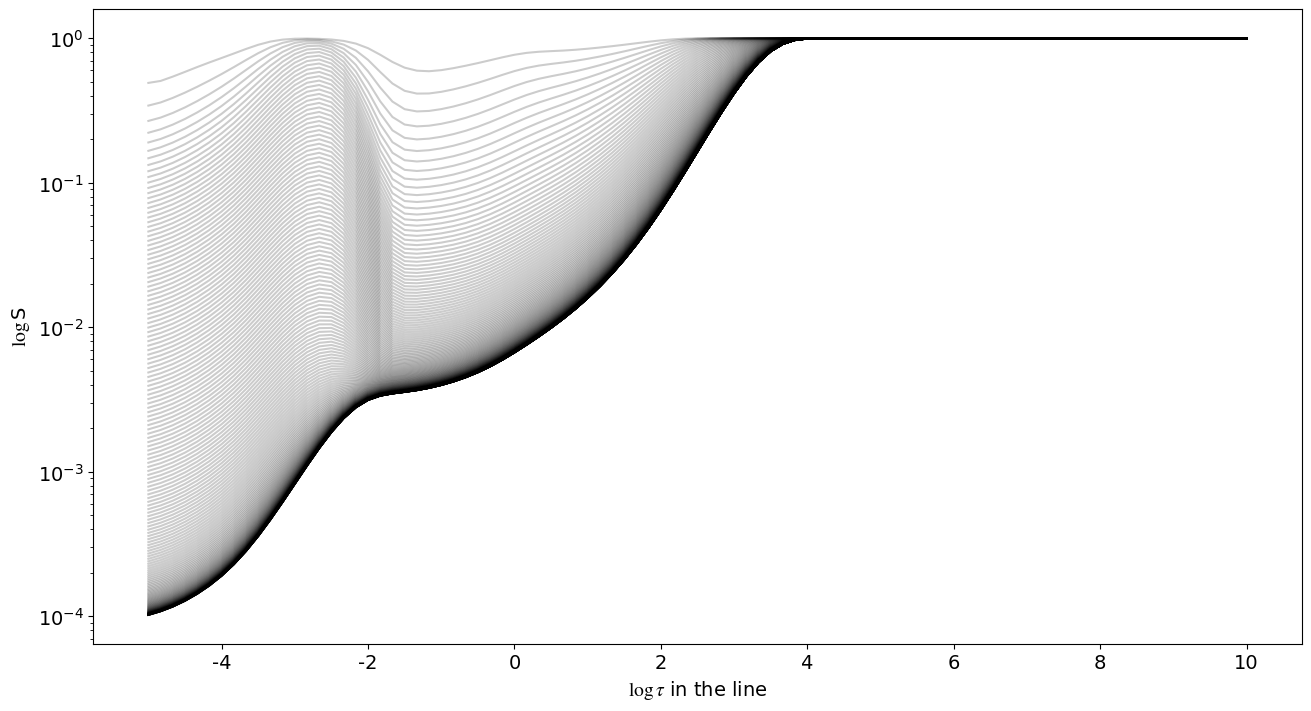

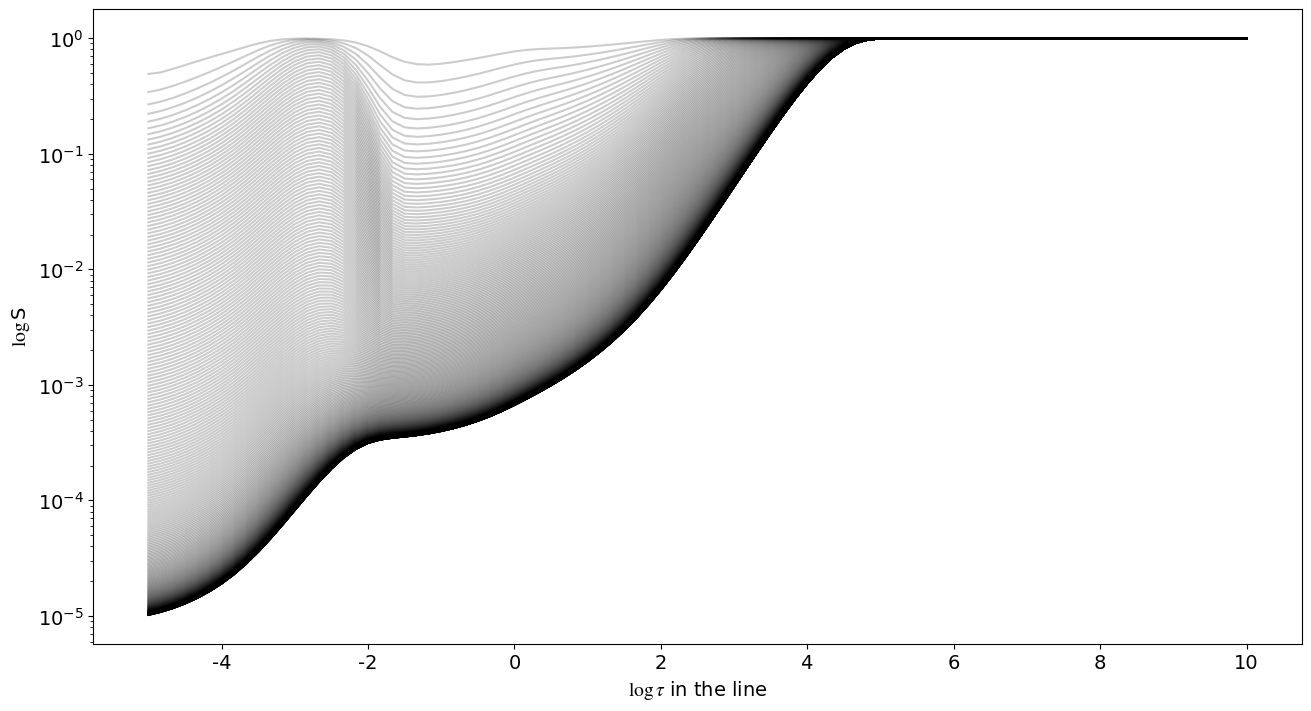

In [31]:
S_Voigt2 = solve_2level_nlte(91, 3, 21, 1.0, 2)
S_Voigt4 = solve_2level_nlte(91, 3, 21, 1.0, 2)
S_Voigt6 = solve_2level_nlte(91, 3, 21, 1.0, 2)
S_Voigt8 = solve_2level_nlte(91, 3, 21, 1.0, 2)
S_Voigt10 = solve_2level_nlte(91, 3, 21, 1.0, 2)

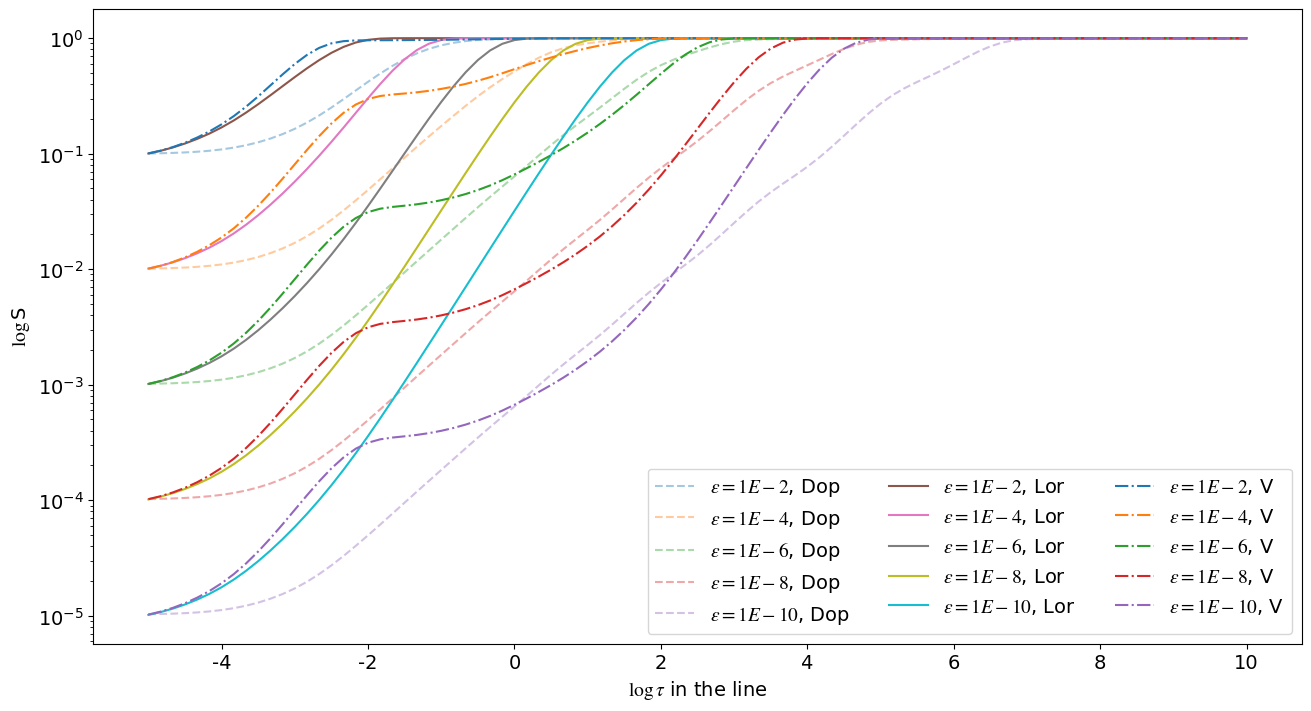

In [32]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("$\\log$S")
plt.semilogy(logtau_Mihalas, logS[0], linestyle = "--", alpha = 0.4, label = "$\\varepsilon = 1E-2$, Dop")
plt.semilogy(logtau_Mihalas, logS[1], linestyle = "--", alpha = 0.4, label = "$\\varepsilon = 1E-4$, Dop")
plt.semilogy(logtau_Mihalas, logS[2], linestyle = "--", alpha = 0.4, label = "$\\varepsilon = 1E-6$, Dop")
plt.semilogy(logtau_Mihalas, logS[3], linestyle = "--", alpha = 0.4, label = "$\\varepsilon = 1E-8$, Dop")
plt.semilogy(logtau_Mihalas, logS[4], linestyle = "--", alpha = 0.4, label = "$\\varepsilon = 1E-10$, Dop")
plt.semilogy(logtau_Mihalas, S_Lorentz2, label = "$\\varepsilon = 1E-2$, Lor")
plt.semilogy(logtau_Mihalas, S_Lorentz4, label = "$\\varepsilon = 1E-4$, Lor")
plt.semilogy(logtau_Mihalas, S_Lorentz6, label = "$\\varepsilon = 1E-6$, Lor")
plt.semilogy(logtau_Mihalas, S_Lorentz8, label = "$\\varepsilon = 1E-8$, Lor")
plt.semilogy(logtau_Mihalas, S_Lorentz10, label = "$\\varepsilon = 1E-10$, Lor")
plt.semilogy(logtau_Mihalas, S_Voigt2, linestyle = "-.", label = "$\\varepsilon = 1E-2$, V")
plt.semilogy(logtau_Mihalas, S_Voigt4, linestyle = "-.", label = "$\\varepsilon = 1E-4$, V")
plt.semilogy(logtau_Mihalas, S_Voigt6, linestyle = "-.", label = "$\\varepsilon = 1E-6$, V")
plt.semilogy(logtau_Mihalas, S_Voigt8, linestyle = "-.", label = "$\\varepsilon = 1E-8$, V")
plt.semilogy(logtau_Mihalas, S_Voigt10, linestyle = "-.", label = "$\\varepsilon = 1E-10$, V")
#plt.tight_layout()
plt.legend(loc = "lower right", ncols = 3)

<h2>Finite slab</h2>

<p>The previous case is probably the most simple way to go about this. For finite slab - limited zones in an atmosphere to which a particular ion is owing to changes in ionization balance; we have a finite optical thickness, and therefore, the boundary conditions have to be changed.</p>

In [54]:
def solve_2level_nlte_slab(ND, NM, NL, B, profile_type, line_ratio = 1E3):
    # ND - number of points for depth/optical depth grid
    # NM - number of points for angle grid
    # NL - number of points for wavelength/frequency grid
    # epsilon - photon probability destruction
    # B - Planck's function
    # profile_type - spectral line profile (Doppler, Voigt or Lorentz) of a in Mihalas)
    # T - the total optical thickness of slab


    # Total optical thickness
    T = float(input("Please enter the value for total optical thickness of the slab: "))
    
    # Optical depth grid
    ll = np.log10(T)
    '''
    What if we want to manually choose lower and upper boundary of the slab
    while maintaining T?
    upp = np.abs(float(input("Please enter the upper boundary in log scale: ")))
    if(upp >= T):
        raise Exception("This can't be greater than T!") 
    dow = T - upp
    logtau = np.linspace(-upp, dow, ND)
    '''
    logtau = np.linspace(-ll/2, ll/2, ND)
    #logtau = np.linspace(-4, 3, ND)
    tau = 10**logtau

    # Planck's function
    B = np.zeros(ND)
    B[:] = 1 # constant with depth (simplified case)
    #print(B)
    
    # Photon probablity destruction
    '''
    In general, epsilon should decrease with height.
    '''
    epsilon = np.zeros(ND)
    epsilon[:] = float(input("Please enter the value for photon destruction probability: ")) # change to suit your needs

    # Reduced wavlength in Doppler widths
    x = np.linspace(-5, 5, NL)
    #print(x)

    
    if (profile_type == 1):
        # Doppler profile
        profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))
    elif profile_type == 2:
        # Voigt profile
        alpha = float(input("Please enter the value for alpha: "))
        gamma = float(input("Please enter the value for gamma: "))
        sigma = alpha / np.sqrt(2 * np.log(2))
        profile = np.real(wofz((x + 1j * gamma) / sigma / np.sqrt(2)))/sigma/np.sqrt(2 * np.pi)
    elif profile_type == 3:
        # Lorentz profile
        profile = 1/np.pi * (1 + x**2)
    else:
        raise Exception("Profile type must be 1 (Doppler), 2 (Voigt) or 3 (Lorentz)")

    wx = np.zeros(NL)

    wx[0] = (x[1] - x[0]) * 0.5
    wx[-1] = (x[-1] - x[-2]) * 0.5
    wx[1:-1] = (x[2:NL] - x[0:-2]) * 0.5
    norm = (np.sum(profile*wx))
    wx = wx/norm
    
    # Angle integration:
    mu=([1./np.sqrt(3.0)])
    wmu=[1.0]
    mu=np.cos([0.4793425352,1.0471975512,1.4578547042])
    wmu=[.2777777778,0.4444444444,0.2777777778]
    NM = mu.shape[0]
    mu = np.asarray(mu)
    wmu = np.asarray(wmu)
    #print(wmu)
    #print(profile)
    #print(mu)
    # Initialize one figure for plotting
    fig = plt.figure(constrained_layout = True, figsize = (13, 7))

    # Solve radiative transfer equation (first by using Ivan's functions)
    S = np.copy(B) # the source function 
    #print(S)
    # We will iterate 'till the convergence
    for j in range(0, 1000):
        J = np.zeros(ND) # initialize the scattering integral
        L = np.zeros(ND) # initialize the Lambda operator
        # For each direction and wavelength, calculate monochromatic intensity and add its contribution to the scattering integral
        for m in range(0, NM):
            for l in range(0, NL):

                # outward

                I_Lambda = sc_2nd_order(tau * profile[l] * lratio, S, mu[m], 0.0*B[-1])

                J = J + I_Lambda[0] * profile[l] * wx[l] * wmu[m] * 0.5

                L = L + I_Lambda[1] * profile[l] * wx[l] * wmu[m] * 0.5

                # inward

                I_Lambda = sc_2nd_order(tau * profile[l] * lratio, S, -mu[m], 0.0)

                J = J + I_Lambda[0] * profile[l] * wx[l] * wmu[m] * 0.5

                L = L + I_Lambda[1] * profile[l] * wx[l] * wmu[m] * 0.5

        # Correct the source function using the local ALI approach
        dS = (epsilon * B + (1. - epsilon) * J - S)/(1. - (1. - epsilon) * L)

        # Check for change
        max_change = np.max(np.abs(dS/S))

        S += dS
        plt.semilogy(logtau, S, '-k', alpha = 0.20)
        if(max_change < 1E-4):
            break
        fin = S    
    plt.xlabel("$\\log\\tau$ in the line")
    plt.ylabel("$\\log$S")
    #plt.tight_layout()
    return fin

Please enter the value for total optical thickness of the slab:  1E4
Please enter the value for photon destruction probability:  1E-2
Please enter the value for total optical thickness of the slab:  1E4
Please enter the value for photon destruction probability:  1E-4
Please enter the value for total optical thickness of the slab:  1E4
Please enter the value for photon destruction probability:  1E-6
Please enter the value for total optical thickness of the slab:  1E4
Please enter the value for photon destruction probability:  1E-8
Please enter the value for total optical thickness of the slab:  1E4
Please enter the value for photon destruction probability:  1E-10
Please enter the value for photon destruction probability:  1E-4


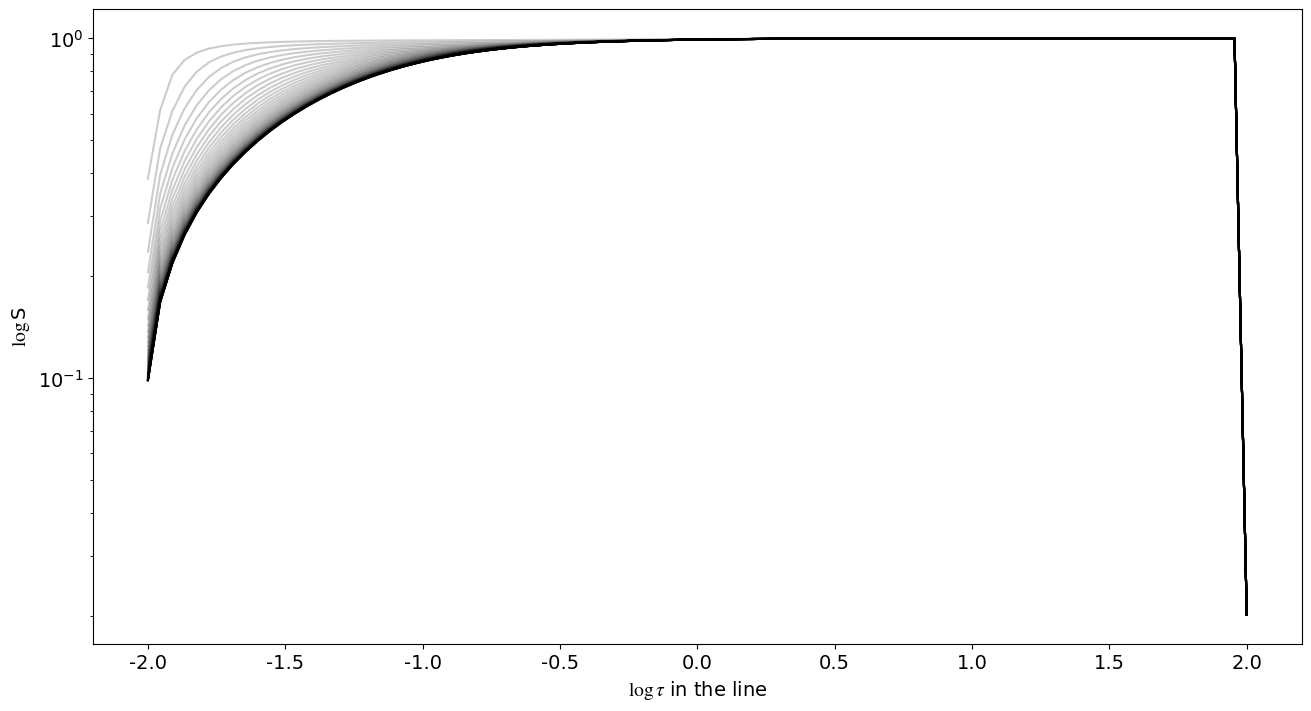

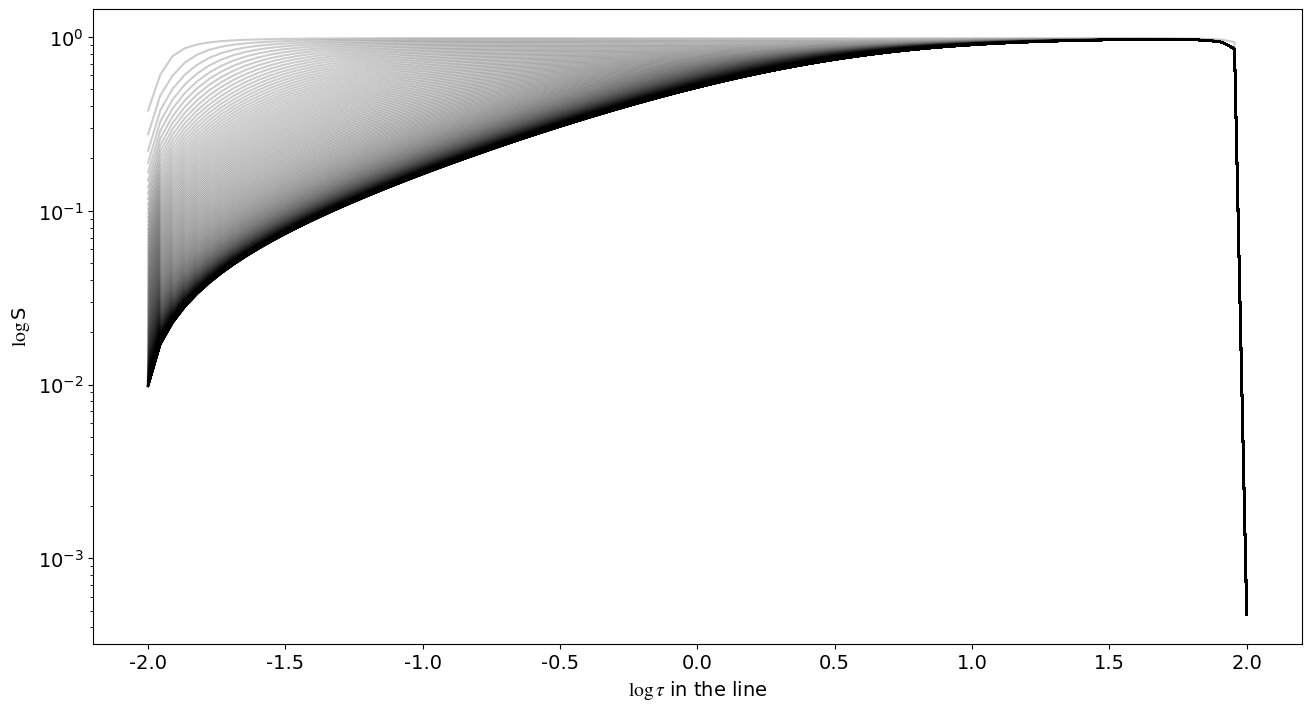

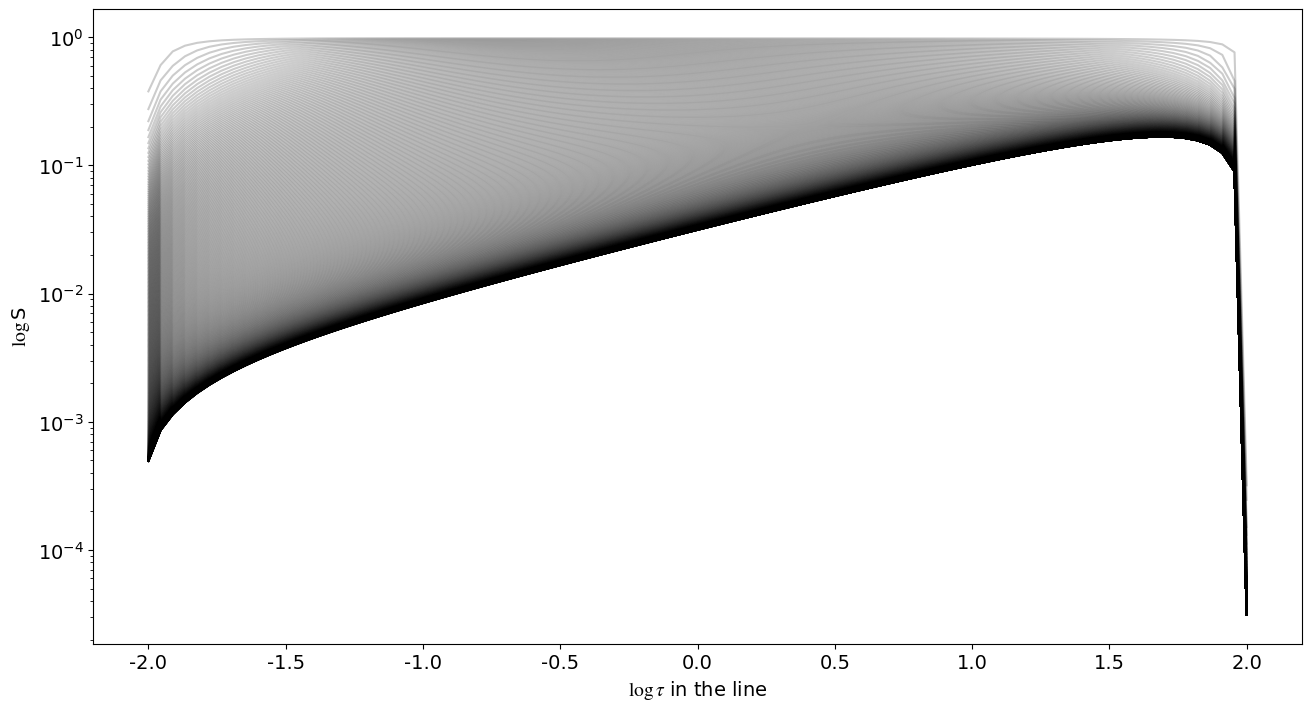

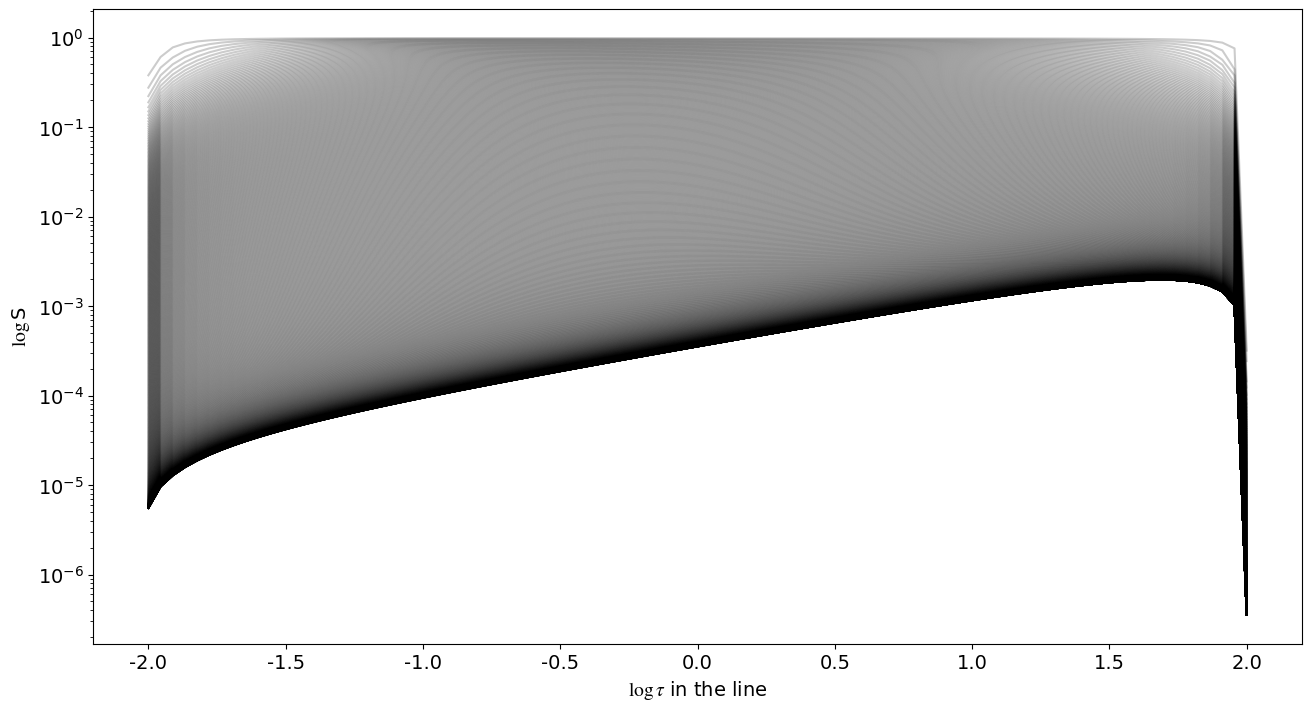

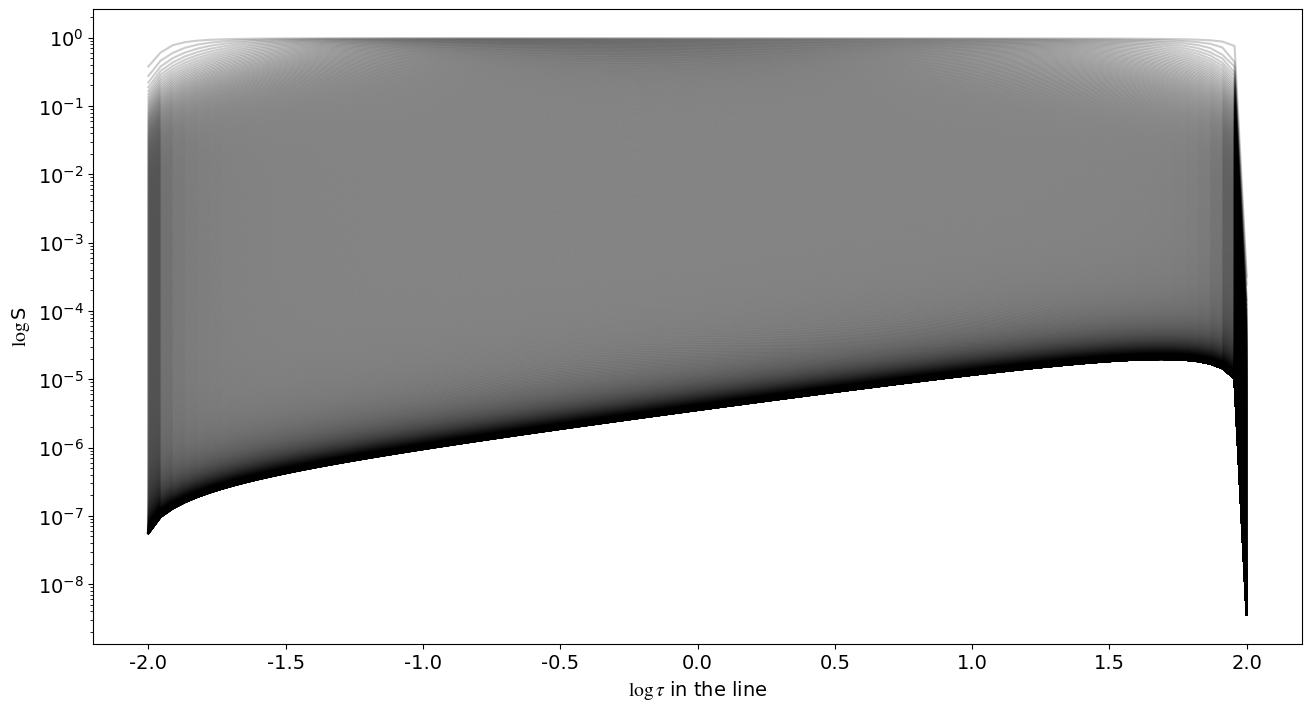

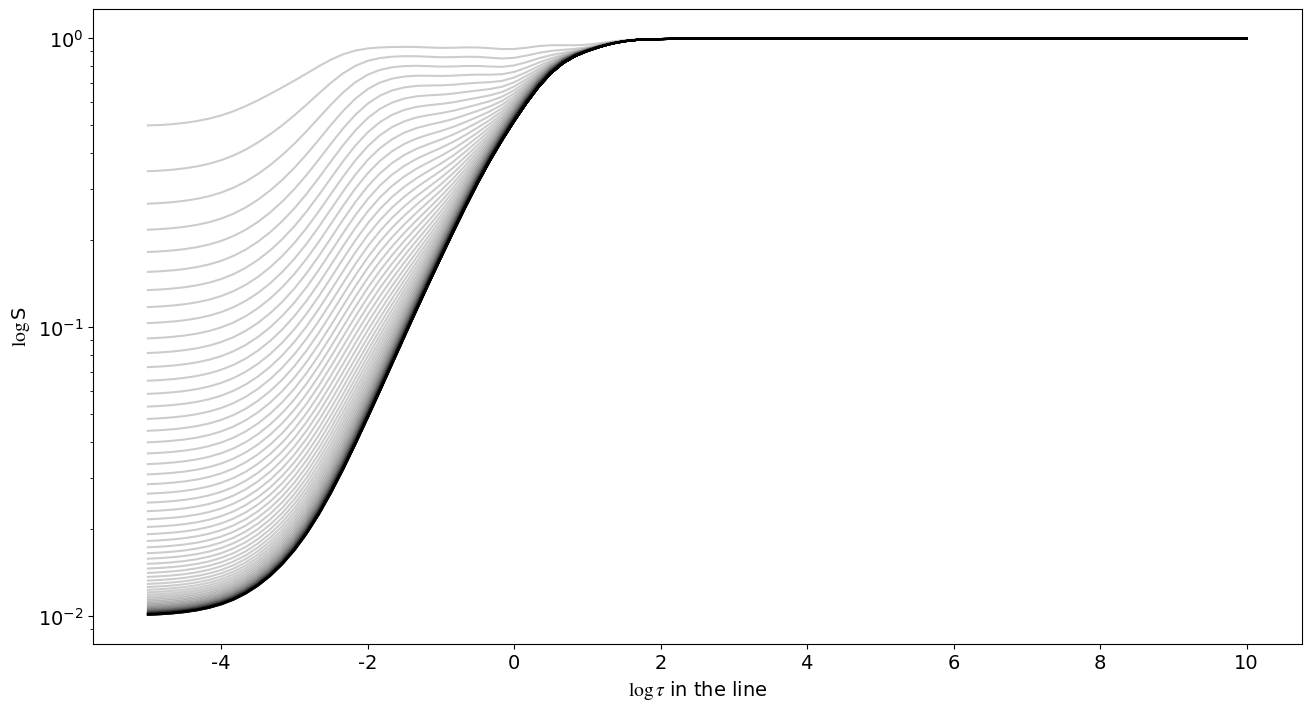

In [56]:
S_D_finite_e2_T4 = solve_2level_nlte_slab(91, 3, 71, 1.0, 1)
S_D_finite_e4_T4 = solve_2level_nlte_slab(91, 3, 71, 1.0, 1)
S_D_finite_e6_T4 = solve_2level_nlte_slab(91, 3, 71, 1.0, 1)
S_D_finite_e8_T4 = solve_2level_nlte_slab(91, 3, 71, 1.0, 1)
S_D_finite_e10_T4 = solve_2level_nlte_slab(91, 3, 71, 1.0, 1)

S_D_e4 = solve_2level_nlte(91, 3, 21, 1.0, 1)

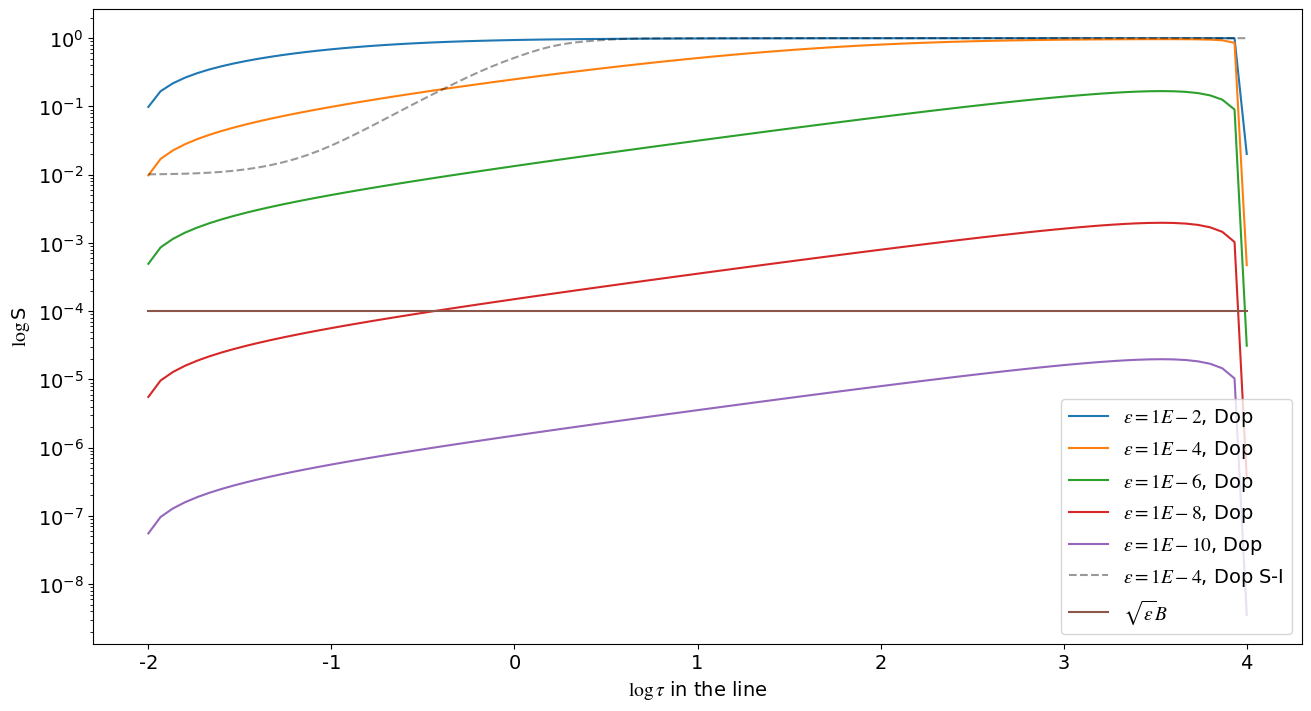

In [57]:
logtau_MihalasM = np.linspace(-2, 4, 91)
povr = np.zeros(91)
povr[:] = np.sqrt(1E-8)*1.0
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("$\\log$S")
plt.semilogy(logtau_MihalasM, S_D_finite_e2_T4, label = "$\\varepsilon = 1E-2$, Dop")
plt.semilogy(logtau_MihalasM, S_D_finite_e4_T4, label = "$\\varepsilon = 1E-4$, Dop")
plt.semilogy(logtau_MihalasM, S_D_finite_e6_T4, label = "$\\varepsilon = 1E-6$, Dop")
plt.semilogy(logtau_MihalasM, S_D_finite_e8_T4, label = "$\\varepsilon = 1E-8$, Dop")
plt.semilogy(logtau_MihalasM, S_D_finite_e10_T4, label = "$\\varepsilon = 1E-10$, Dop")
plt.semilogy(logtau_MihalasM, S_D_e4, alpha = 0.4, linestyle = "--", color = "black", label = "$\\varepsilon = 1E-4$, Dop S-I")
plt.plot(logtau_MihalasM, povr, label = "$\sqrt{\\varepsilon}B$")
#plt.tight_layout()
plt.legend(loc = "lower right", ncols = 1)

Please enter the value for total optical thickness of the slab:  1E2
Please enter the value for photon destruction probability:  1E-4
Please enter the value for total optical thickness of the slab:  1E4
Please enter the value for photon destruction probability:  1E-4
Please enter the value for total optical thickness of the slab:  1E6
Please enter the value for photon destruction probability:  1E-4
Please enter the value for total optical thickness of the slab:  1E8
Please enter the value for photon destruction probability:  1E-4
Please enter the value for photon destruction probability:  1E-4


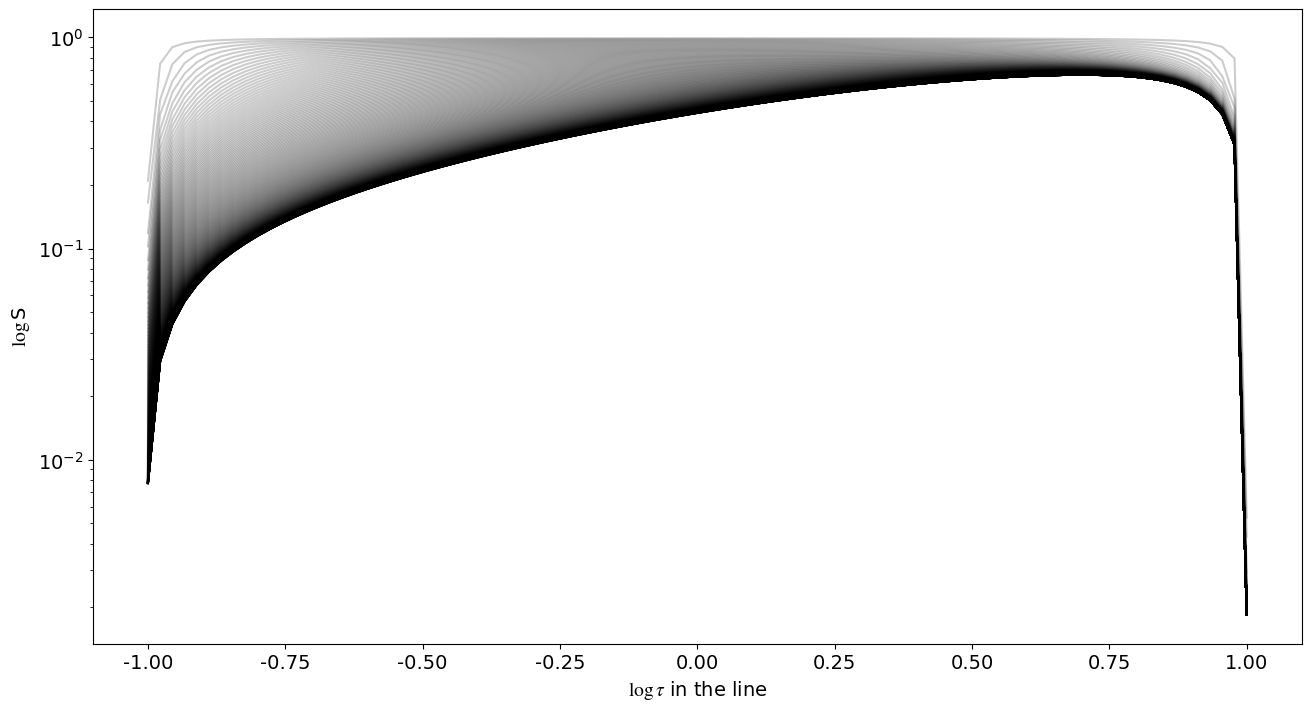

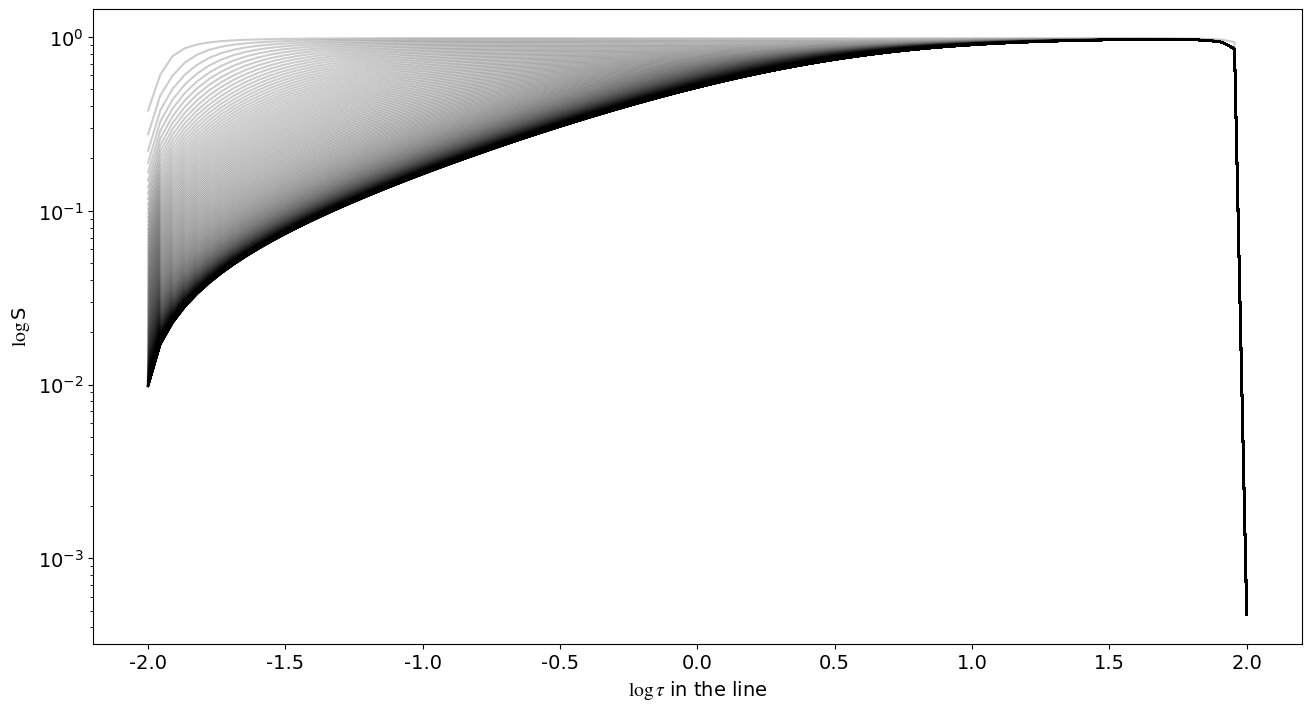

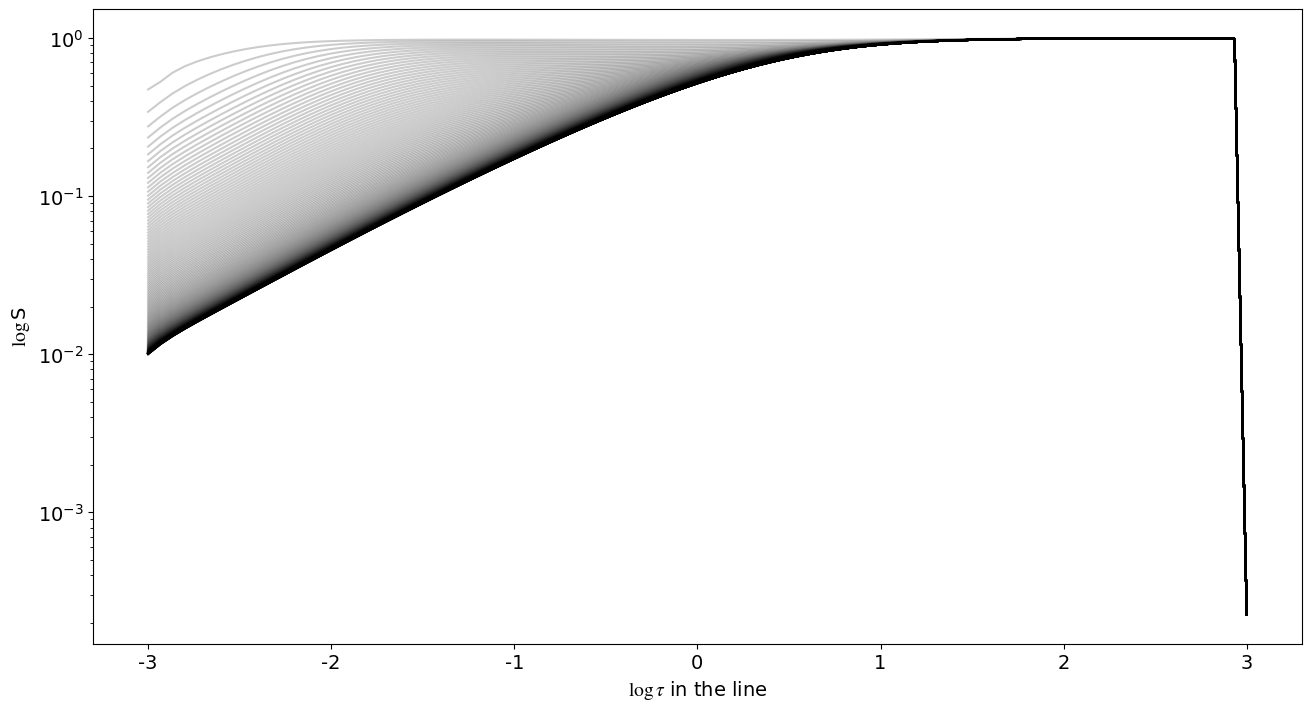

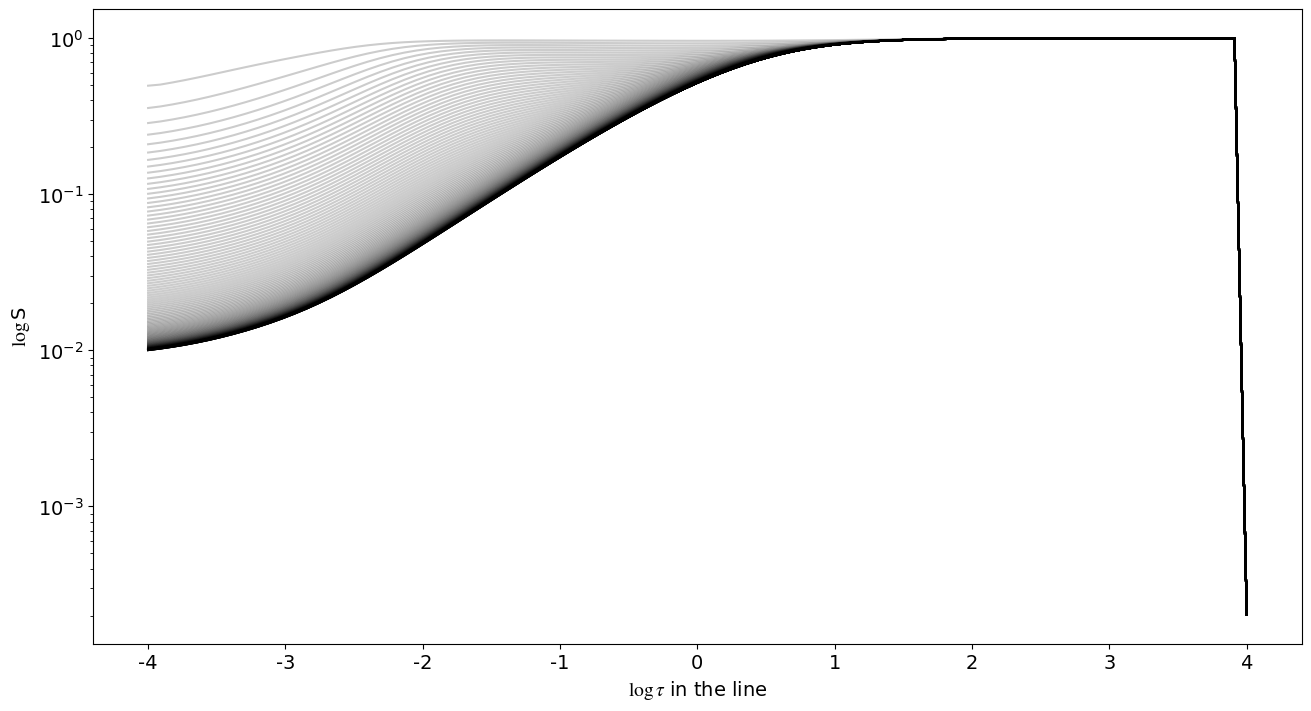

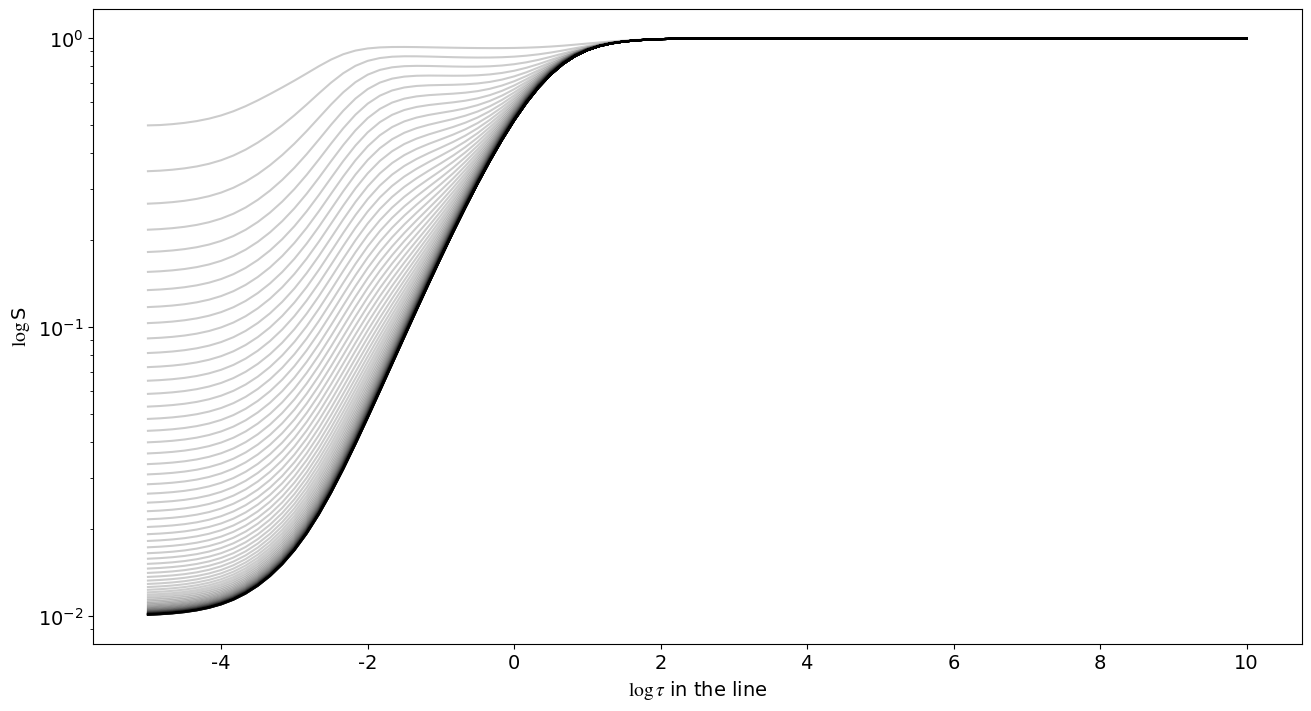

In [58]:
x = np.linspace(-5, 5, 71)
profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))


logtau2 = np.linspace(-2/2, 2/2, 91)
tau2 = 10**logtau2

logtau4 = np.linspace(-4/2, 4/2, 91)
tau4 = 10**logtau4

logtau6 = np.linspace(-6/2, 6/2, 91)
tau6 = 10**logtau6

logtau8 = np.linspace(-8/2, 8/2, 91)
tau8 = 10**logtau8

logtaui = np.linspace(-5, 10, 91)
taui = 10**logtaui

S_D_finite_e4_T2 = solve_2level_nlte_slab(91, 3, 71, 1.0, 1)
I_out2 = one_full_fs(tau2*lratio,S_D_finite_e4_T2,1.0,profile,S_D_finite_e4_T2[-1])

S_D_finite_e4_T4 = solve_2level_nlte_slab(91, 3, 71, 1.0, 1)
I_out4 = one_full_fs(tau4*lratio,S_D_finite_e4_T4,1.0,profile,S_D_finite_e4_T4[-1])

S_D_finite_e4_T6 = solve_2level_nlte_slab(91, 3, 71, 1.0, 1)
I_out6 = one_full_fs(tau6*lratio,S_D_finite_e4_T6,1.0,profile,S_D_finite_e4_T6[-1])

S_D_finite_e4_T8 = solve_2level_nlte_slab(91, 3, 71, 1.0, 1)
I_out8 = one_full_fs(tau8*lratio,S_D_finite_e4_T8,1.0,profile,S_D_finite_e4_T8[-1])

S_D_e4 = solve_2level_nlte(91, 3, 71, 1.0, 1)
I_outinf = one_full_fs(taui*lratio,S_D_e4,1.0,profile,S_D_e4[-1])

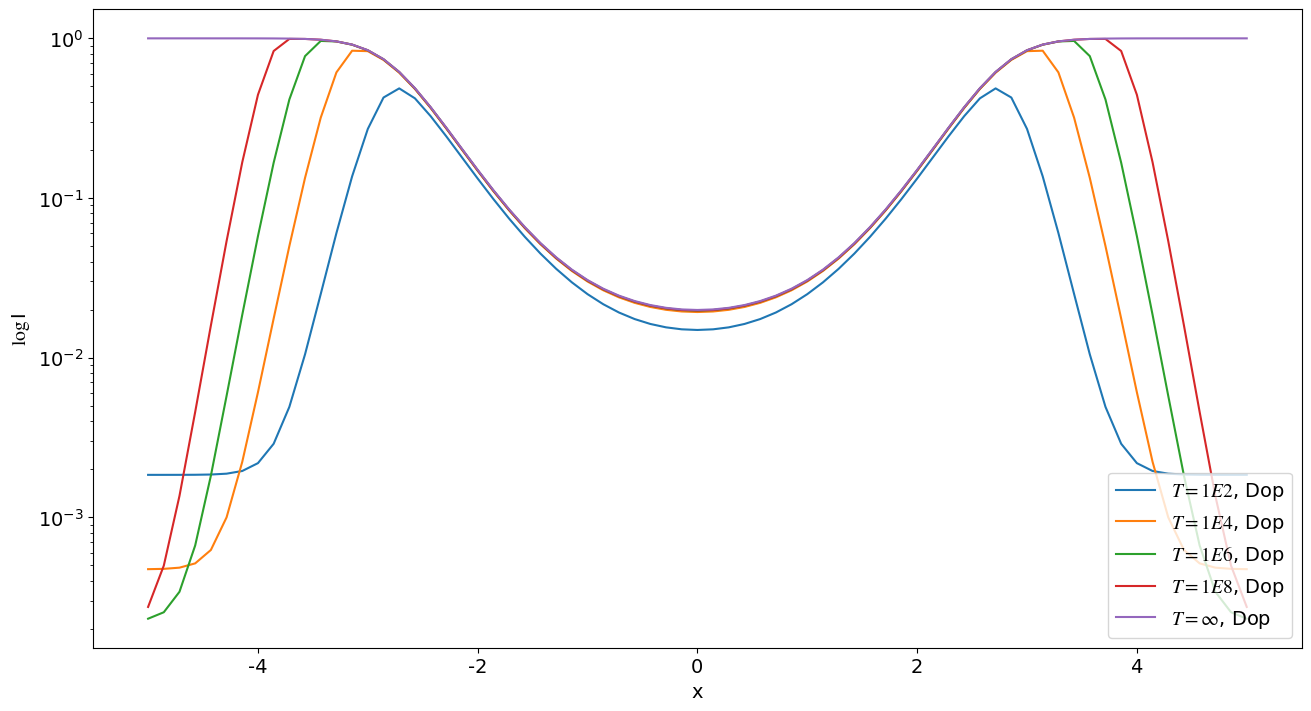

In [59]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("x")
#plt.xlim(0,5)
plt.ylabel("$\\log$I")
plt.semilogy(x, I_out2, label = "$T = 1E2$, Dop")
plt.semilogy(x, I_out4, label = "$T = 1E4$, Dop")
plt.semilogy(x, I_out6, label = "$T = 1E6$, Dop")
plt.semilogy(x, I_out8, label = "$T = 1E8$, Dop")
plt.semilogy(x, I_outinf, label = "$T = \infty$, Dop")
plt.legend(loc = "lower right", ncols = 1)

<h2>15. 09. 2025.</h2>

<p>Our next task is to see how changing the line ratio affects the line source function. This is shown in Fig. 11-5 in Mihalas (1978), 2nd edition. For this, we shall go back to semi-infinite atmospheres.</p>

Please enter the value for photon destruction probability:  1E-6
Please enter the value for photon destruction probability:  1E-6
Please enter the value for photon destruction probability:  1E-6
Please enter the value for photon destruction probability:  1E-6
Please enter the value for photon destruction probability:  1E-6
Please enter the value for photon destruction probability:  1E-6


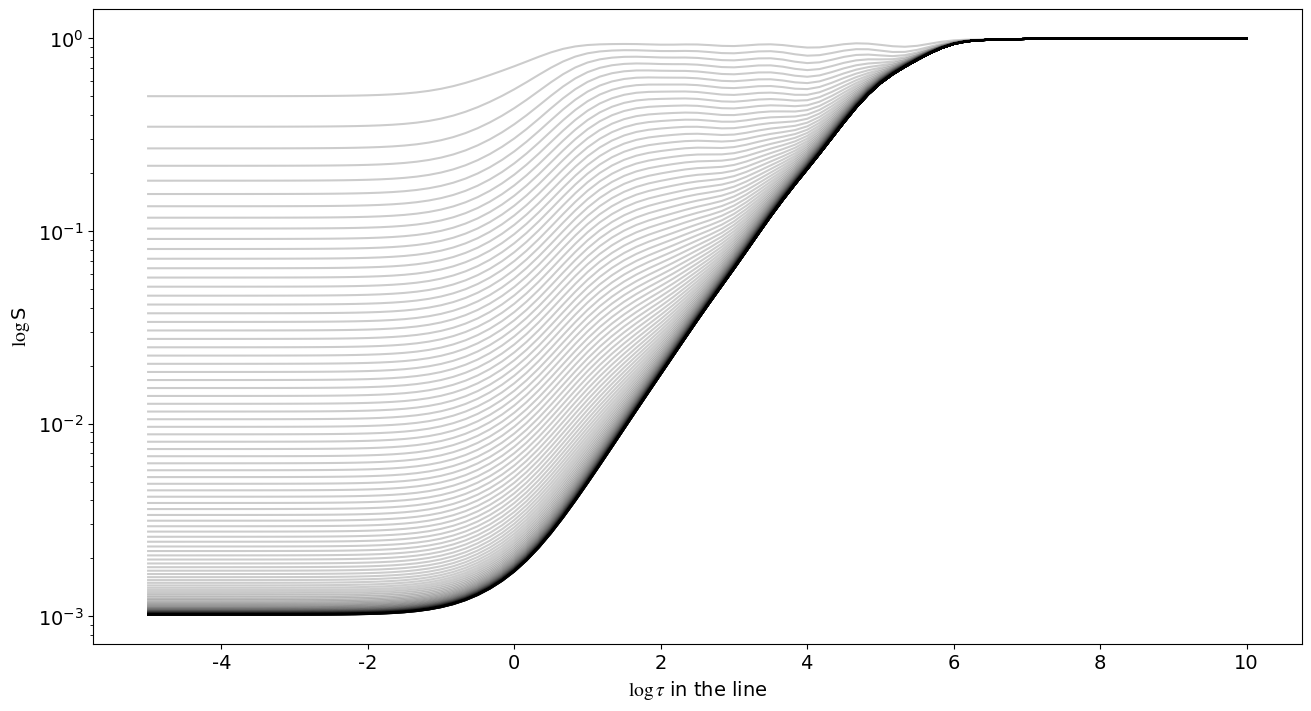

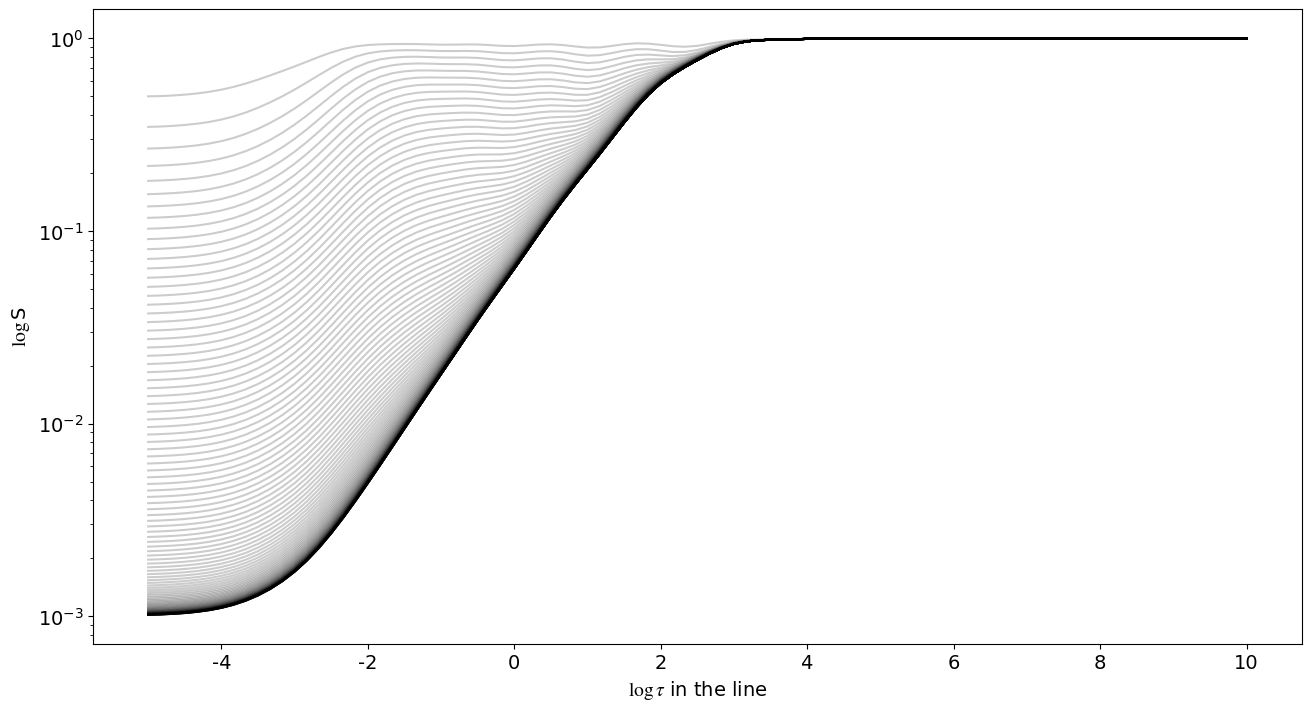

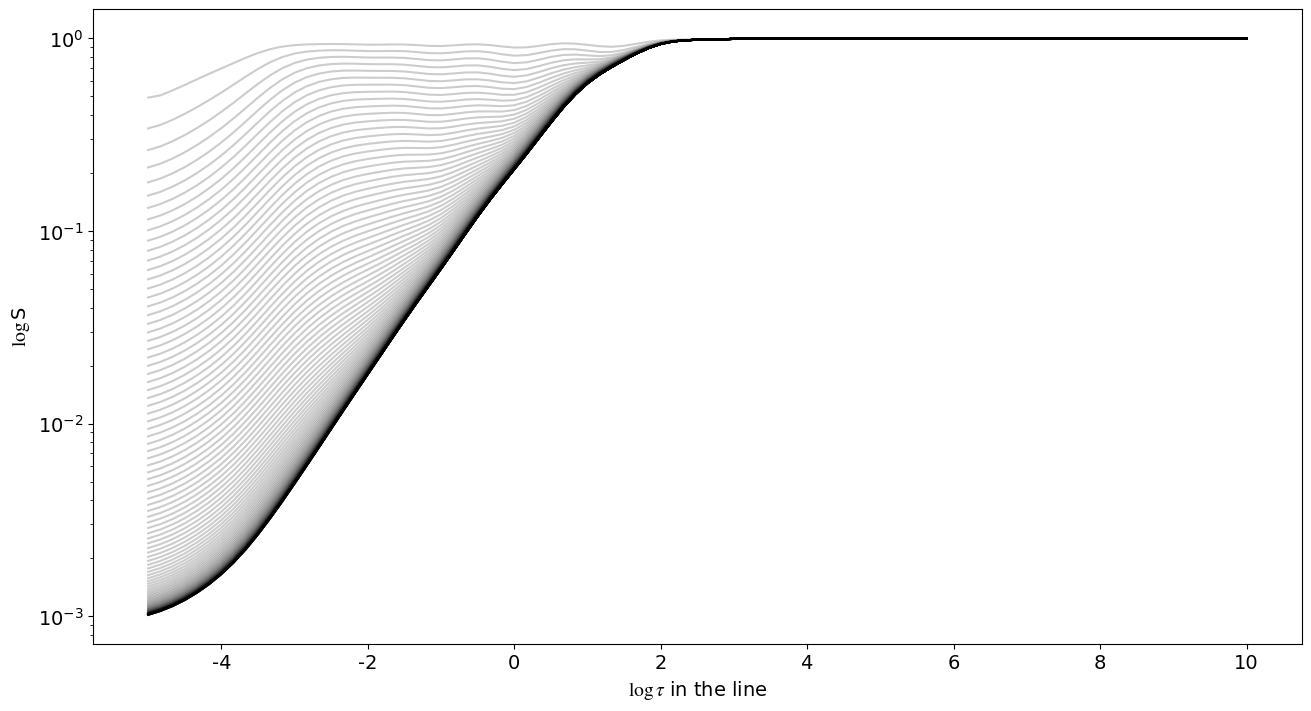

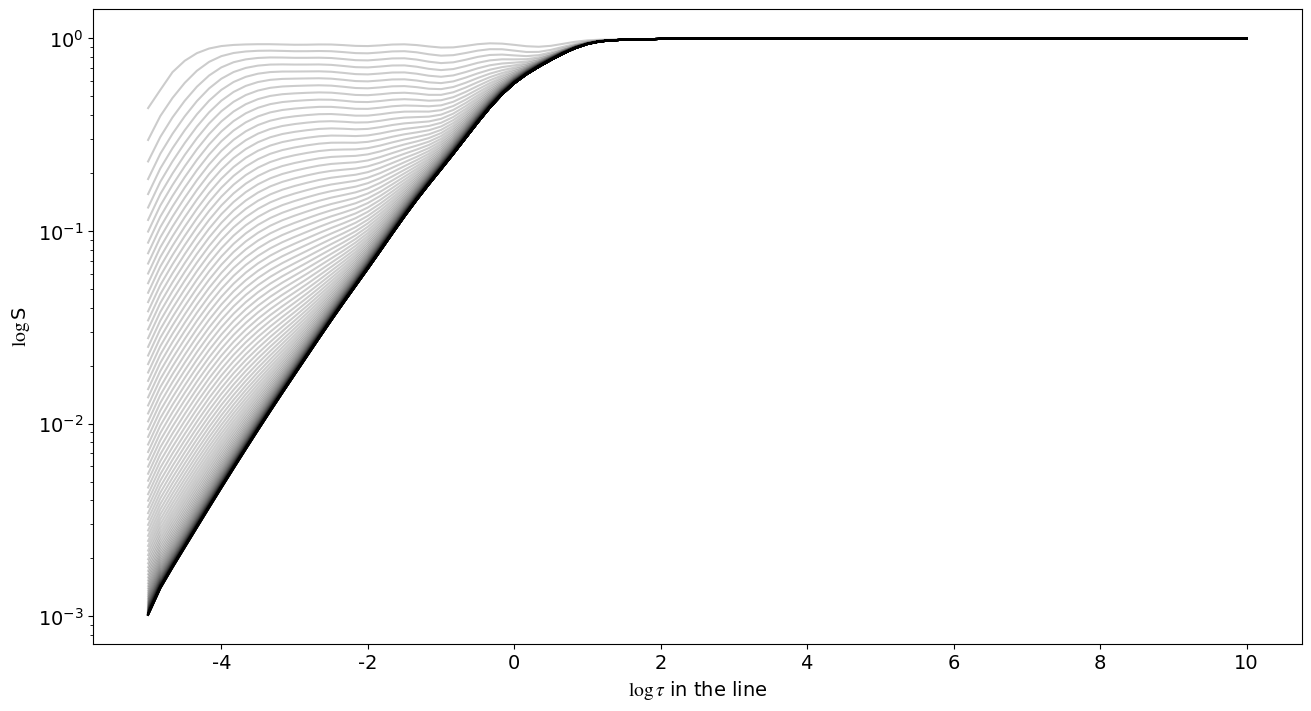

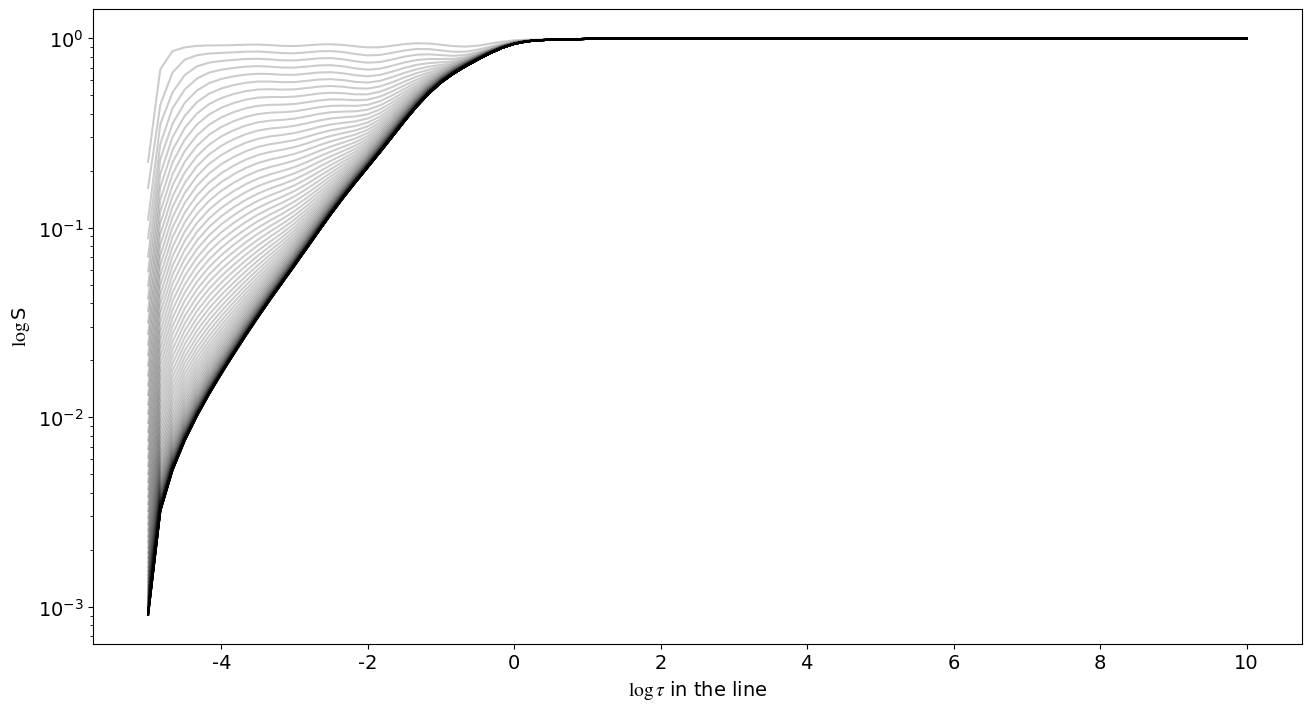

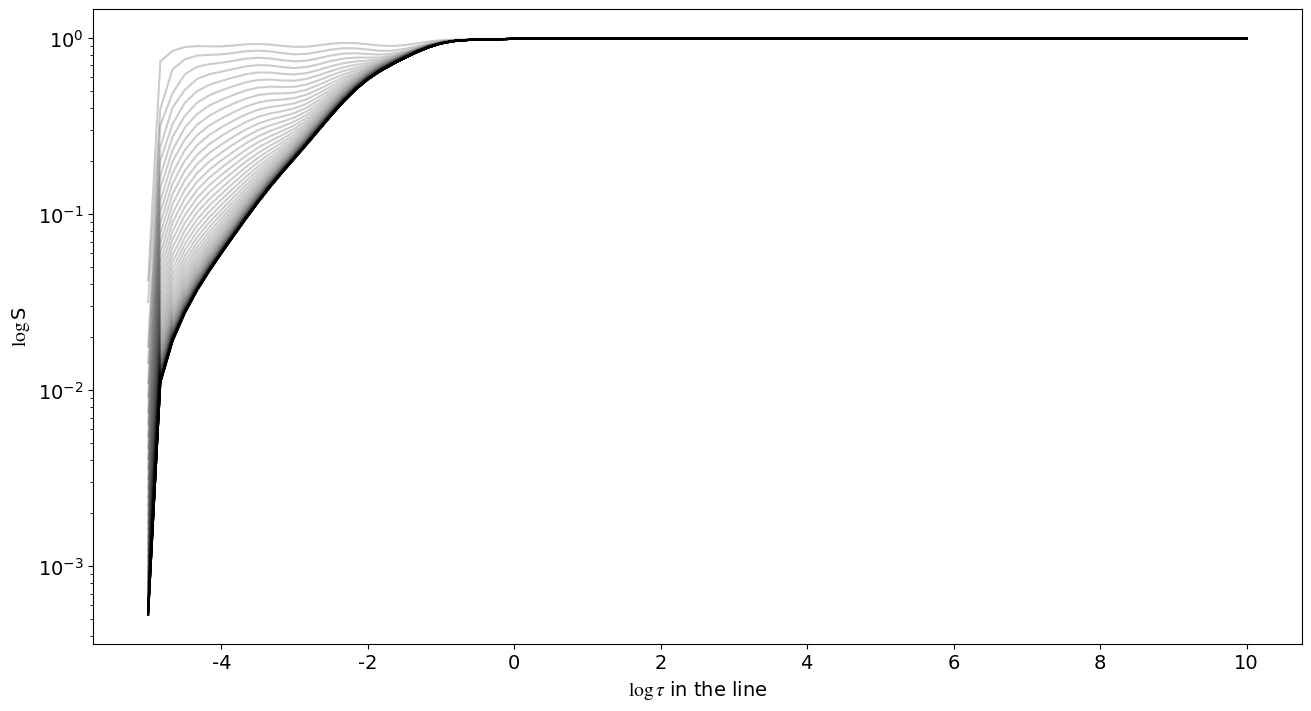

In [70]:
# Doppler profiles with epsilon = 1E-6 and r (line ratio) from 1E-3 to 1E-7
S_r_m3 = solve_2level_nlte(91, 3, 21, 1.0, 1, line_ratio = 1E3)
lratio = 1E3
S_r_m4 = solve_2level_nlte(91, 3, 21, 1.0, 1, line_ratio = 1E4)
lratio = 1E4
S_r_m5 = solve_2level_nlte(91, 3, 21, 1.0, 1, line_ratio = 1E5)
lratio = 1E5
S_r_m6 = solve_2level_nlte(91, 3, 21, 1.0, 1, line_ratio = 1E6)
lratio = 1E6
S_r_m7 = solve_2level_nlte(91, 3, 21, 1.0, 1, line_ratio = 1E7)
lratio = 1E7
S_r_m0 = solve_2level_nlte(91, 3, 21, 1.0, 1, line_ratio = 1)
lratio = 1

<h2>15. 09. 2025.</h2> 



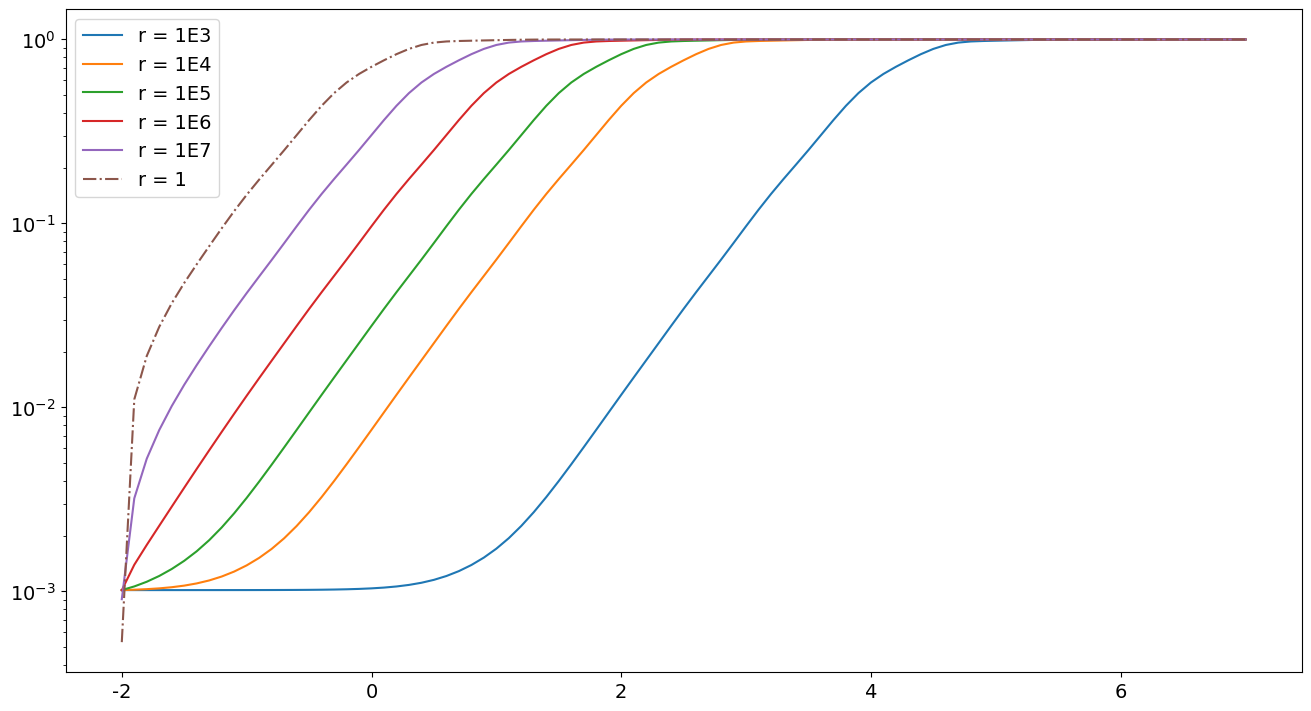

In [71]:
logtau_Mihalas_R = np.linspace(-2, 7, nd)
plt.figure(constrained_layout = True, figsize = (13, 7))
plt.semilogy(logtau_Mihalas_R, S_r_m3, linestyle = "-", label = "r = 1E3")
plt.semilogy(logtau_Mihalas_R, S_r_m4, linestyle = "-", label = "r = 1E4")
plt.semilogy(logtau_Mihalas_R, S_r_m5, linestyle = "-", label = "r = 1E5")
plt.semilogy(logtau_Mihalas_R, S_r_m6, linestyle = "-", label = "r = 1E6")
plt.semilogy(logtau_Mihalas_R, S_r_m7, linestyle = "-", label = "r = 1E7")
plt.semilogy(logtau_Mihalas_R, S_r_m0, linestyle = "-.", label = "r = 1")
plt.legend()